# feature extraction for logistic ADNI models
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [20]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [21]:
import seaborn as sns
import scipy

### Loading ADNI flair mask t1 dataset

In [22]:
# ADNI_ds = MRI_3D_nolabels_inram_ds("/home/s2208943/ipdis/data/preprocessed_data/ADNI_300")

In [23]:
# IDs = ADNI_ds.getIDs()

In [24]:
# len(IDs)

### Loading ADNI predictions

In [25]:
# def get_output_maps_for_ds(output_maps_dir, ids):
#     output_maps_lists = defaultdict(lambda : [])
#     key_order = None
#     for ID in tqdm(ids, position=0, leave=True):
#         output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
#         key_order = natsorted(list(output_maps_data.keys()))
#         for output_type in key_order:
#             output_maps_lists[ID].append(torch.from_numpy(output_maps_data[output_type]))
            
#     return output_maps_lists, key_order
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True):
        # print(fID)
        # break
        if ".npz" in fID:
            ID = fID.split(".")[0]
            output_maps_data = np.load(output_maps_dir+fID)
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [26]:
# model_name = "SSN_Ens_Mean"
model_name = "SSN_Ens"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/{model_name}/"
output_maps_for_umaps, key_order = load_output_maps(output_maps_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [03:12<00:00,  1.51it/s]


In [27]:
model_name_for_pred = "SSN_Ens_Mean"
output_maps_dir_for_pred = f"/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/{model_name_for_pred}/"
output_maps_for_pred, key_order_for_pred = load_output_maps(output_maps_dir_for_pred)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [04:52<00:00,  1.01s/it]


In [28]:
key_order

['ent', 'pred', 'seg', 'var']

In [29]:
ID = list(output_maps_for_umaps.keys())[2]

In [30]:
img_us = output_maps_for_umaps[ID]
img_ps = output_maps_for_pred[ID]

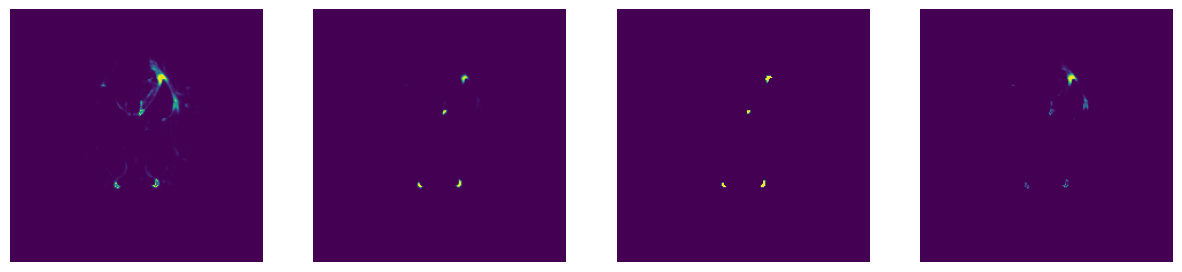

In [31]:
plt.figure(figsize=(15,4))
islice = 31
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(img_us[i][islice])
    plt.axis('off')

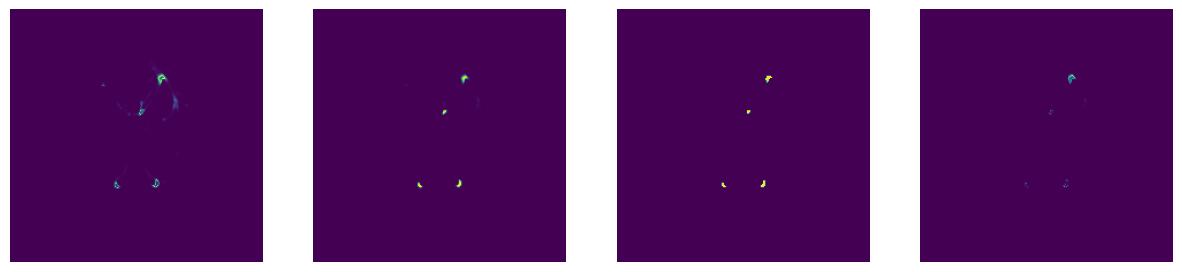

In [32]:
ent, pred, seg, var = img_ps
plt.figure(figsize=(15,4))
islice = 31
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(img_ps[i][islice])
    plt.axis('off')

In [33]:
t = 0.1
ent_voxels = ent[ent > t]
pred_voxels = pred[pred > t]
var_voxels = var[var > t/10]

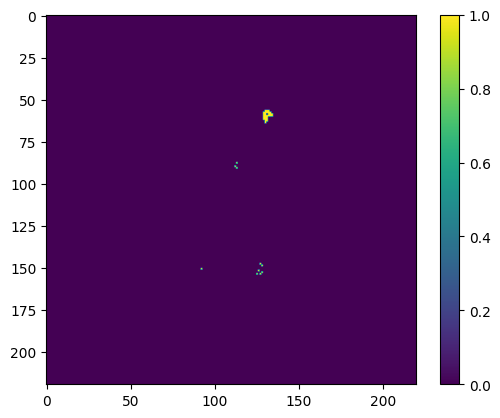

In [34]:
plt.imshow(var[islice]>0.01)
plt.colorbar()

<AxesSubplot: ylabel='Density'>

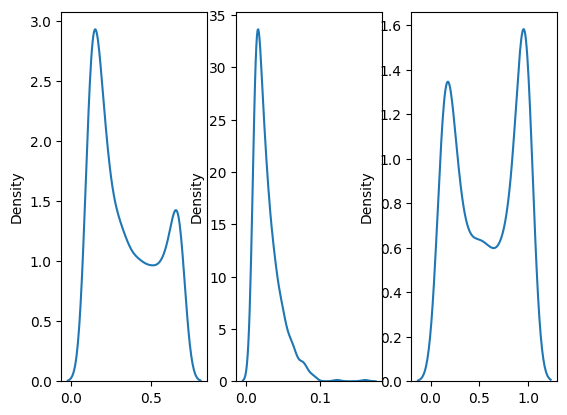

In [35]:
plt.subplot(1,3,1)
sns.kdeplot(ent_voxels)
plt.subplot(1,3,2)
sns.kdeplot(var_voxels)
plt.subplot(1,3,3)
sns.kdeplot(pred_voxels)

In [36]:
def histogram_distribution(values, bins=20, minv=None, maxv=None):
    # so that the output values are meaningful, I need to carefully set the min a max. mnin should be t, and max should be the max across all the data I think.
    if minv == None:
        minv = values.min()
    if maxv == None:
        maxv = values.max()
    counts = torch.zeros(bins)
    bounds = torch.arange(minv,maxv, (maxv-minv)/bins)
    for i, (lower_bound, upper_bound) in enumerate(zip(bounds[:-1], bounds[1:])):
        counts[i] = ((values >= lower_bound) * (values < upper_bound)).sum()

    Z = counts.sum()
    counts = counts / Z
    return counts

In [37]:
def gaussian_summary_statistics(values):
    sum = values.sum().item()
    mean = values.mean().item()
    std = values.std().item()
    skew = scipy.stats.skew(values)
    kurtosis = scipy.stats.kurtosis(values, fisher=False)
    return sum, mean, std, skew, kurtosis

In [38]:
histogram_distribution(ent_voxels, 20)

tensor([0.1462, 0.1206, 0.0885, 0.0729, 0.0589, 0.0457, 0.0461, 0.0408, 0.0399,
        0.0309, 0.0379, 0.0325, 0.0276, 0.0342, 0.0309, 0.0280, 0.0362, 0.0333,
        0.0490, 0.0000])

In [39]:
# counts, counts.sum()

<AxesSubplot: ylabel='Count'>

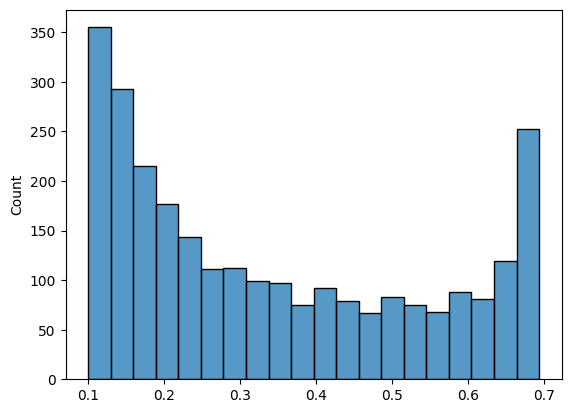

In [40]:
sns.histplot(ent_voxels, bins=20)

### overlap proportions computation
- [x] proportion of segmented area that is uncertain
- [x] proportion of uncertain area that is segmented
- [x] proportion of uncertain area that is within segmentation + edge expansion

In [41]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

### loading the ventricles for ventricle distance analysis

In [42]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as tv

# resamples an image
def get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1., 1., 3.], is_label=False):
    
    if not original_spacing:
        # orig spacing can be specified when the input itk_image does not know its actual spacing.
        original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)
      
def resample_and_return(filename_in, is_label=False, out_spacing=[1., 1., 3.], original_spacing=None):
    """
    resamples an image to custom voxel dimensions and returns image as a numpy array
    
    filename_in: .nii.gz file to load
    is_label: is the file a brain scan or a segmentaion mask
    outspacing: the spacing of the image to be resampled to.
    """
        
    # resample the image
    image = sitk.ReadImage(filename_in)
    resampled_image = get_resampled_img(image, out_spacing=out_spacing, original_spacing=original_spacing, is_label=is_label)
    
    return sitk.GetArrayFromImage(resampled_image)

In [43]:
# this loop takes a while as its loading from disk and resampling
# it takes around 11 minutes

cropper = tv.transforms.CenterCrop((220, 220))

def load_fast_output(file, slices):
    timg = resample_and_return(file, is_label=True)
        
    # interpolate the channel number and centre crop
    timg = torch.Tensor(timg)
    timg = torch.nn.functional.interpolate(timg.unsqueeze(0).unsqueeze(0), (slices, *timg.shape[1:])).squeeze()
    timg = cropper(timg.view((1, 1, *timg.shape))).squeeze()
    
    return timg



In [44]:
IDs_outmaps = natsorted(list(output_maps_for_umaps.keys()))
IDs = [("_".join(idx.split("_")[:-2]), idx) for idx in IDs_outmaps if "out_maps" in idx]

In [45]:
output_maps_for_umaps[IDs[0][1]][0].shape

torch.Size([58, 220, 220])

In [46]:
vent_folder = "/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_ventmapper/"
vent_filenames = os.listdir(vent_folder)
ID_ventpath_map = {"_".join(f.split("_")[:-1]): vent_folder + f for f in vent_filenames}
vent_maps = []
for i in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[i]
    num_slices = output_maps_for_umaps[ID[1]][0].shape[0]
    vent_path = ID_ventpath_map[ID[0]]
    vent_seg = load_fast_output(vent_path, num_slices)
    vent_maps.append(vent_seg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:47<00:00,  6.17it/s]


In [47]:
vent_maps[0].shape, vent_maps[0].sum(dim=(1,2,)).argmax(0)

(torch.Size([58, 220, 220]), tensor(33))

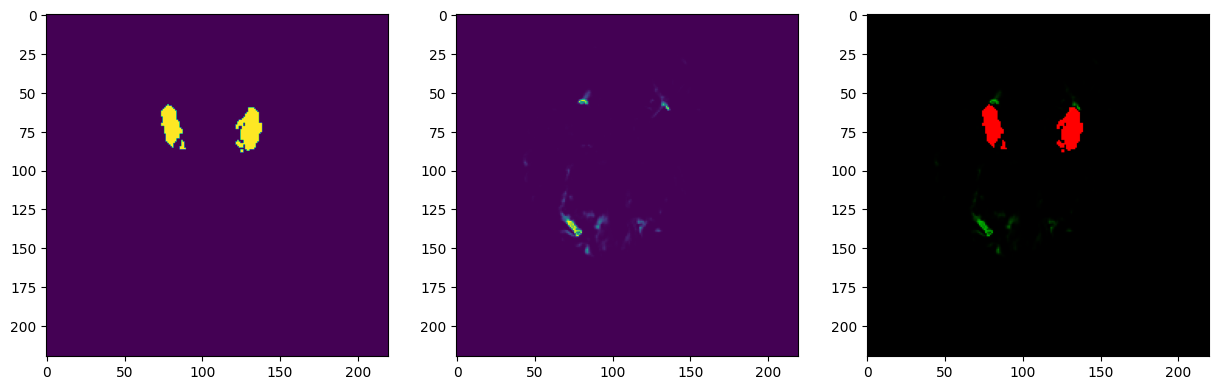

In [48]:
islice = 26
scan_id = 200
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(vent_maps[scan_id][islice])
plt.subplot(1,3,2)
plt.imshow(output_maps_for_umaps[IDs[scan_id][1]][0][islice])
plt.subplot(1,3,3)
img_map = torch.zeros(*vent_maps[0].shape[1:], 3)
img_map[:,:,0] = vent_maps[scan_id][islice]
img_map[:,:,1] = output_maps_for_umaps[IDs[scan_id][1]][0][islice]
plt.imshow(img_map)

### distance from the ventricles

In [49]:
import torch.nn.functional as F
def edge_pixels_3D(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32).unsqueeze(0)
    
    max_pool = F.max_pool3d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool3d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype).squeeze()

def edge_pixels(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32)
    
    max_pool = F.max_pool2d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool2d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype)

In [50]:
def downsample_3d(img, avg=True):
    if avg:
        return F.avg_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)
    else:
        return F.max_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)

In [51]:
def min_distances(img, vmap):
    # calculate the minimum distance between each point in a and each point in b
    
    spatial_dims = vmap.squeeze().shape
    grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                indexing='ij'
            )
        ).type(torch.float32).to(img.device)
    
    a = grid[:, img.squeeze() > 0].T.cuda()
    b = grid[:, vmap.squeeze() > 0].T.cuda()
    
    # Calculate pairwise distances between all pairs of points
    distances = torch.cdist(a, b)

    # Find indices of closest points in b for each point in a
    _, indices = torch.min(distances, dim=1)

    # Use indices to index into b and get closest points
    b_closest = b[indices]

    # Calculate distances to closest points 
    distances_closest = torch.norm(a - b_closest, dim=1)
    
    distance_map = torch.zeros(img.shape).to(distances_closest.device)
    distance_map[img > 0] = distances_closest
    
    return distances_closest, distance_map

### connected components analysis

In [52]:
import cc3d

In [53]:
def get_conn_comps(img):
    connectivity = 6 # only 4,8 (2D) and 26, 18, and 6 (3D) are allowed
    labels_out_seg = cc3d.connected_components(img.cpu().numpy(), connectivity=connectivity)
    return torch.from_numpy(labels_out_seg.astype(np.int16)).to(img.device)

In [54]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

In [55]:
def skew(t, dim=None):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`

    :return: a scalar
    """

    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(3)).mean(dim=dim)


def kurtosis(t, fisher=True, dim=None):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)

    :return: a scalar
    """
        
    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(4)).mean(dim=dim) - fisher*3

In [56]:
def one_hot_encoded_image(image):
    # for a 3D [H, W, D] shape image
    # ensure all IDs are unique
    return (image == image.unique().view(-1, 1, 1, 1))

def one_hot_encoded_vector(vector):
    return (vector == vector.unique().view(-1,1))

In [57]:
def conn_comp_basic_stats(umap, conn_comp_map, seg_map, dist_map):
    # number of connected components
    # size of connected components
    # connected component size distribution information
    cc_ids = conn_comp_map.unique()
    cc_locs = conn_comp_map != 0
    conn_comp_map = conn_comp_map[cc_locs]
    umap = umap[cc_locs]
    seg_map = seg_map[cc_locs]
    dist_map = dist_map[cc_locs]
    
    assert dist_map.shape == seg_map.shape == umap.shape == conn_comp_map.shape
    num_ccs = len(cc_ids) - 1
    num_ccs_no_overlap = 0
    cc_sizes = []
    cc_means = []
    cc_stds = []
    cc_skews = []
    cc_kurts = []
    cc_vent_dists = []
    for cc_id in cc_ids:
        if cc_id == 0:
            continue
        cc = conn_comp_map == cc_id
        cc_size = cc.sum().item()
        cc_values = umap[cc]
        _, mean, std, skew, kurtosis = gaussian_summary_statistics(cc_values.cpu())
    
        cc_sizes.append(cc_size)
        cc_means.append(mean)
        cc_stds.append(std)
        cc_skews.append(skew)
        cc_kurts.append(kurtosis)
        
        if seg_map[cc].sum() == 0:
            num_ccs_no_overlap += 1
            
        cc_vent_dists.append(dist_map[cc].mean().item())
    _, vd_mean, vd_std, vd_skew, vd_kurt = gaussian_summary_statistics(torch.Tensor(cc_vent_dists))
    _, size_mean, size_std, size_skew, size_kurt = gaussian_summary_statistics(torch.Tensor(cc_sizes))
    
    return {"num":num_ccs, "sizes":cc_sizes, "means":cc_means, "stds":cc_stds, "skews":cc_skews, "kurts":cc_kurts, "vent_dists":cc_vent_dists, "unsegmented_ccs":num_ccs_no_overlap, "size_mean":size_mean, "size_std":size_std, "size_skew":size_skew, "size_kurt":size_kurt, "vd_mean":vd_mean, "vd_std":vd_std, "vd_skew":vd_skew, "vd_kurt":vd_kurt}



In [58]:
# idx = 0
# example_umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
# example_smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
# example_vmap = vent_maps[idx].cuda()

# vmap_ds = downsample_3d(example_vmap)
# umap_ds = downsample_3d(example_umap)
# ut_ds = umap_ds > 0.1
# ut = example_umap > 0.1
# conn_comps = get_conn_comps(ut)

# distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
# distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), example_umap.shape, mode='trilinear').squeeze()

In [59]:
# cc_data = conn_comp_basic_stats(example_umap, conn_comps, example_smap, distance_map) # from this we could get the mean mean, mean std, mean skew and mean kurtosis for each threshold I guess. # that would be somewhat interesting

In [60]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [61]:
# cc_data["log_sizes"] = torch.Tensor(cc_data['sizes']).log()
# sns.jointplot(cc_data, y="vent_dists", x="log_sizes", bins=5, kind='hist')

In [62]:
def joint_hist_values(data, x, y, minx, maxx, miny, maxy, bins=5):
    values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
    values = values.expand((bins, bins, *values.shape))
    counts = torch.zeros(bins, bins)
    bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1)).to(values.device)
    bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1)).to(values.device)
    upper_xlims = bounds_x[1:].view(1, 5, 1)
    upper_ylims = bounds_y[1:].view(5, 1, 1)
    lower_xlims = bounds_x[:-1].view(1, 5, 1)
    lower_ylims = bounds_y[:-1].view(5, 1, 1)
    counts = (values[:,:,:,0] < upper_xlims) * (values[:,:,:,0] > lower_xlims) * (values[:,:,:,1] < upper_ylims) * (values[:,:,:,1] > lower_ylims)
    counts = counts.sum(dim=-1)

    Z = counts.sum()
    counts = counts / Z
    return counts


# def joint_hist_values2(data, x, y, minx, maxx, miny, maxy, bins=5):
#     values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
#     #values = values.expand((bins, bins, *values.shape))
#     counts = torch.zeros(bins, bins)
#     bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1))
#     bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1))
#     upper_xlims = bounds_x[1:]
#     upper_ylims = bounds_y[1:]
#     lower_xlims = bounds_x[:-1]
#     lower_ylims = bounds_y[:-1]
#     for i, (x1, x2) in enumerate(zip(lower_xlims, upper_xlims)):
#         for j, (y1,y2) in enumerate(zip(lower_ylims, upper_ylims)):
#             counts[i][j] = ((values[:,0] < x2) * (values[:,0] > x1) * (values[:,1] < y2) * (values[:,1] > y1)).sum()
#     # counts = counts.sum(dim=-1)

#     Z = counts.sum()
#     counts = counts / Z
#     return counts

In [63]:
# joint_counts = joint_hist_values2(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5)

In [64]:
# joint_counts.shape

In [65]:
# plt.imshow(joint_counts); plt.colorbar()

In [66]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [67]:
# summary statistics of log conn comp size:
# cc_summary_stats = gaussian_summary_statistics(torch.Tensor(cc_data['sizes']).log())

In [68]:
# sum, mean , std, skew, kurtosis of log size of connected components.
# cc_summary_stats

In [69]:
# histogram_distribution(torch.Tensor(cc_data['sizes']).log(), 10)

In [70]:
# plt.hist(torch.Tensor(cc_data['sizes']).log(), bins=10);

In [71]:
# sns.jointplot(data=cc_data, x="sizes", y="kurts")
# plt.xscale('log')

In [72]:
# lets get basic distribution of connected component numbers and size. Then we can get some interesting plots later, so collect as much interesting information as possible...
# I can compare this to number and size of connected components in the predicted map (at say tau > 0.5?)
# I should get distance of each connected component from the ventricles and size. yes that is a good plot
# also distance from the binarized segmentation... (but I need to be careful and do this for pred as well as umap).

### Uncertainty values that I intended to extract from the umap

For SSN Ens for the ent and var maps, and SSN Ens Mean for the pred and seg maps. Nice.
I should capture all of these metrics across a variety of metrics, and I can tune the thresholds in cross validation. simples.
It may be the case that ent + var together give us some more information. That would be interesting.

`output_maps_for_umaps` is the SSN_Ens output
`output_maps_for_mean` is the SSN_Ens_mean output

- [x] sum
- [x] mean
- [x] std
- [x] skew
- [x] kurtosis
- [x] kde bins?
- [x] ventricle size
- [x] intensity distribution (need to ensure that the min and max of the bins are the same across all individuals) 
- [x] number of connected components
- [x] size of connected components distribution, need to ensure that the min and max of the bins are the same across all individuals.
- [x] number / distribution of connected components that have no overlap with the segmented mask... (again I need the umap and the pred map to do this) (and I should also compare to the seg map as well perhaps)
- [x] uncertainty sum, mean, skew, kurtosis of each connected component. That may be interesting to plot.
- [-] distance to the WMH binarized segmentation for each connected component (try to separate out those connected components that are highlighting other stuff).
- [-] proportion of the segmented edge deemed uncertain (if we expand the edge of the segmentation then calculate the proportion, we can get the sum of the uncertainty that
- [x] proportion of segmented area deemed uncertain (this requires access to SSN Ens and SSN Ens Mean at the same time
- [x] proportion of uncertain area that is within the segmentation + edge area
- [x] distribution of size of connected components (sum, mean, std, skew)
- [x] distance from the ventricles (could do this in x, y and z distributions, or just overall...) I could measure distance x intensity
- [x] stats for distance from the ventricles (mean, std, skew, kurtosis, etc)
- [x] mean distance from the ventricles of each connected component joint with size in a 5x5 and 10x10 bin option I think. again ensure that the 
- [ ] predicted seg volume.

### turning all of the above into a big loop

need to compute values for:
- [x] ent map
- [x] var map
- [x] pred map
- [x] loop over [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5] as threshold for ent map
- [x] loop over [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] for pred map
- [x] loop over ? for ent map

In [73]:
data = {}
failed_ids = []
for idx in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[idx][0]
    print(ID)
    try:
        vmap = vent_maps[idx].cuda()
        smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
        smap_expanded = get_edge_expanded_seg(smap)
        seg_volume = smap.sum().item()
        vent_volume = vmap.sum().item()
        vmap_ds = downsample_3d(vmap)

        ind_data = {}

        for input_type in ["ent", "var", "pred"]:
            if input_type == "ent":
                umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]
                maxv = 0.7
            elif input_type == "var":
                umap = output_maps_for_umaps[IDs[idx][1]][3].cuda()
                ts = [0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
                maxv = 0.2
            elif input_type == "pred":
                umap = output_maps_for_pred[IDs[idx][1]][1].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
                maxv = 1.0
            else:
                raise ValueError  

            umap_ds = downsample_3d(umap)

            collected_data_t = {}

            for t in ts:
                ut = umap > t
                umap_values = umap[ut]

                #### summary statistics
                sum, mean, std, skew, kurtosis = gaussian_summary_statistics(umap_values.cpu())
                values_hist = histogram_distribution(umap_values, bins=20, minv=t, maxv=maxv)

                #### overlap statistics
                intersection = (ut * smap).sum()
                expanded_intersection = (ut * smap_expanded).sum()

                prop_umap_segmented = (intersection / ut.sum()).item()
                prop_umap_within_expanded_seg = (expanded_intersection / ut.sum()).item()
                prop_seg_uncertain = (intersection / smap.sum()).item()

                ### ventricle distance statistics
                ut_ds = umap_ds > t
                distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
                distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), umap.shape, mode='trilinear').squeeze()
                _, dist_mean, dist_std, dist_skew, dist_kurt = gaussian_summary_statistics(distances_closest.cpu())
                umap_ds_values = umap_ds[ut_ds]
                dist_value_joint = joint_hist_values({"x":distances_closest, "y":umap_ds_values}, x="x", y="y", minx=0, maxx=30, miny=t, maxy=maxv, bins=5).cpu()

                ### connected component analysis statistics
                conn_comps = get_conn_comps(ut)
                cc_data = conn_comp_basic_stats(umap, conn_comps, smap, distance_map)
                cc_data["log_sizes"] = torch.Tensor(cc_data["sizes"]).log()
                cc_size_dist_joint = joint_hist_values(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5).cpu()

                # recorded values
                all_data = {}
                for key, value in cc_data.items():
                    all_data["cc_" + key] = value
                all_data["sum"] = sum
                all_data["mean"] = mean
                all_data["std"] = std
                all_data["skew"] = skew
                all_data["kurtosis"] = kurtosis
                all_data["prop_umap_segmented"] = prop_umap_segmented
                all_data["prop_umap_within_expanded_seg"] = prop_umap_within_expanded_seg
                all_data["prop_seg_uncertain"] = prop_seg_uncertain
                all_data["dist_mean"] = dist_mean
                all_data["dist_std"] = dist_std
                all_data["dist_skew"] = dist_skew
                all_data["dist_kurt"] = dist_kurt
                all_data["dist_value_joint"] = dist_value_joint
                all_data["cc_dist_value_joint"] = cc_size_dist_joint
                all_data["seg_volume"] = seg_volume
                all_data["vent_volume"] = vent_volume
                all_data["values_hist"] = values_hist

                print(all_data["cc_num"], all_data["cc_unsegmented_ccs"])
                collected_data_t[str(t)] = all_data


                # break

            ind_data[input_type] = collected_data_t
            # break

        data[ID] = ind_data
        # break
    except:
        failed_ids.append((idx, ID))
        

  0%|                                                                                                                                                                 | 0/290 [00:00<?, ?it/s]

ADNI_002_S_0729_20110816


/tmp/ipykernel_318894/1284179010.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = scipy.stats.skew(values)
/tmp/ipykernel_318894/1284179010.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = scipy.stats.kurtosis(values, fisher=False)


250 244
211 197
178 156
226 144
250 131
348 145
229 209
299 213
392 236
365 197
222 122


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1417: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)


86 45
58 31
58 22
53 12
52 6
56 0


  0%|▌                                                                                                                                                      | 1/290 [00:24<1:56:02, 24.09s/it]

55 0
ADNI_002_S_1155_20111222
289 282
184 173
146 126
84 52
88 44
102 41
235 223
194 171
166 129
136 88
77 45
36 22
35 21
26 12
17 3


  1%|█                                                                                                                                                      | 2/290 [00:29<1:02:54, 13.10s/it]

15 1
16 0
14 0
ADNI_002_S_1261_20110314
270 259
177 162
141 123
118 82
117 70
109 56
207 195
201 166
191 144
153 110
104 79
59 30
48 28
37 15
34 8
31 4


  1%|█▌                                                                                                                                                       | 3/290 [00:35<47:01,  9.83s/it]

29 0
27 0
ADNI_002_S_1280_20110504
236 224
166 152
130 106
145 86
183 96
231 100
214 195
239 182
282 131
265 111
106 50
37 22
57 34
49 19
43 10
43 6


  1%|██                                                                                                                                                       | 4/290 [00:42<41:44,  8.76s/it]

42 0
36 0
ADNI_002_S_2010_20101022
265 255
168 154
103 85
80 54
86 52
85 45
205 192
150 130
115 89
96 65
57 30
43 20
30 15
26 11
21 5
19 3


  2%|██▋                                                                                                                                                      | 5/290 [00:47<34:34,  7.28s/it]

16 0
17 0
ADNI_002_S_4213_20111205
207 197
130 117
103 84
80 50
109 59
112 53
168 155
121 100
116 86
134 84
92 50
61 33
41 20
40 17
35 8
35 3


  2%|███▏                                                                                                                                                     | 6/290 [00:52<30:32,  6.45s/it]

37 0
35 0
ADNI_002_S_4225_20111226
380 352
227 192
142 103
125 71
147 80
173 79
283 242
229 177
183 108
162 80
117 62
80 51
67 27
68 27
59 14
63 9
59 0


  2%|███▋                                                                                                                                                     | 7/290 [00:59<32:03,  6.80s/it]

54 0
ADNI_002_S_4229_20111221
414 392
270 241
219 180
187 133
195 130
216 135
341 309
293 234
296 209
267 178
177 131
130 96
63 26
54 13
54 11
47 2
49 0


  3%|████▏                                                                                                                                                    | 8/290 [01:08<35:34,  7.57s/it]

48 0
ADNI_002_S_4237_20110926
436 423
310 293
282 259
205 169
216 162
233 154
359 343
335 309
300 244
298 209
237 147
180 115
114 66
89 30
89 23
81 9
81 0


  3%|████▋                                                                                                                                                    | 9/290 [01:19<40:09,  8.57s/it]

72 0
ADNI_002_S_4262_20111005
299 274
276 237
255 204
268 176
322 181
388 196
299 252
355 247
495 286
460 270
237 139
147 91
124 55
104 31
105 23
93 8
95 0


  3%|█████▏                                                                                                                                                  | 10/290 [01:31<45:02,  9.65s/it]

97 0
ADNI_002_S_4270_20111011
189 182
132 120
91 77
101 64
127 65
171 71
156 143
138 102
180 98
176 73
98 41
34 19
43 24
34 13
30 7
33 6


  4%|█████▊                                                                                                                                                  | 11/290 [01:36<38:38,  8.31s/it]

32 0
35 0
ADNI_002_S_4447_20120814
204 187
169 147
141 111
109 55
138 62
172 65
154 132
193 147
246 140
190 91
89 38
42 17
48 18
54 19
47 10
51 7


  4%|██████▎                                                                                                                                                 | 12/290 [01:42<35:19,  7.63s/it]

48 0
45 0
ADNI_002_S_4473_20120823
421 402
307 285
246 219
179 140
151 106
144 84
334 310
295 268
257 206
214 133
156 86
102 55
66 31
56 20
53 11
51 5


  4%|██████▊                                                                                                                                                 | 13/290 [01:51<36:35,  7.93s/it]

52 0
49 0
ADNI_002_S_4521_20120904
284 270
188 173
124 103
108 64
111 56
130 58
213 195
186 147
168 109
164 86
102 58
50 35
28 11
38 14
33 8
34 6


  5%|███████▎                                                                                                                                                | 14/290 [01:57<33:27,  7.27s/it]

33 0
28 0
ADNI_002_S_4654_20121023
201 185
149 129
116 94
112 63
140 72
155 67
178 159
159 124
208 131
166 112
94 51
44 27
53 26
42 14
40 9
41 8


  5%|███████▊                                                                                                                                                | 15/290 [02:02<31:03,  6.78s/it]

36 0
32 0
ADNI_006_S_4150_20111107
261 251
140 129
107 90
68 46
79 41
101 43
185 174
159 129
188 117
91 46
56 29
48 19
23 9
21 7
19 4
18 3
16 0


  6%|████████▍                                                                                                                                               | 16/290 [02:07<28:06,  6.15s/it]

15 0
ADNI_006_S_4153_20111104
218 212
142 136
88 78
76 56
90 49
127 57
188 180
130 116
159 93
201 89
133 52
61 20
35 18
46 24
40 17
36 8


  6%|████████▉                                                                                                                                               | 17/290 [02:13<26:53,  5.91s/it]

33 0
30 0
ADNI_006_S_4192_20111215
342 321
249 223
189 156
165 119
206 134
238 133
273 247
290 233
340 227
321 210
201 120
124 84
92 52
77 35
62 18
55 8
50 0


  6%|█████████▍                                                                                                                                              | 18/290 [02:22<31:13,  6.89s/it]

54 0
ADNI_006_S_4357_20111128
222 219
127 122
85 71
118 75
123 64
147 67
157 151
136 105
134 82
141 81
71 41
28 17
38 22
27 11
24 8
29 8
26 0


  7%|█████████▉                                                                                                                                              | 19/290 [02:27<28:26,  6.30s/it]

30 0
ADNI_006_S_4363_20111116
136 129
83 74
61 39
74 35
100 41
130 53
89 80
116 78
142 69
119 58
63 36
36 19
28 15
27 10
24 7
24 4


  7%|██████████▍                                                                                                                                             | 20/290 [02:31<25:07,  5.58s/it]

21 0
22 0
ADNI_006_S_4485_20120824
298 270
217 182
168 118
233 114
330 124
434 145
248 205
295 159
414 161
320 110
142 66
57 28
71 32
70 26
68 18
62 9


  7%|███████████                                                                                                                                             | 21/290 [02:40<30:33,  6.82s/it]

62 0
59 0
ADNI_006_S_4679_20120601
291 276
189 163
163 116
177 94
222 108
264 113
261 230
232 162
260 129
231 95
135 67
54 36
61 31
56 22
51 16
43 8


  8%|███████████▌                                                                                                                                            | 22/290 [02:48<31:41,  7.09s/it]

40 0
42 0
ADNI_006_S_4713_20121128
194 184
127 115
87 68
112 71
139 74
148 63
149 135
159 101
168 86
137 63
79 41
19 14
35 22
26 10
22 5


  8%|████████████                                                                                                                                            | 23/290 [02:53<28:34,  6.42s/it]

23 3
22 0
22 0
ADNI_006_S_4960_20121009
282 263
187 161
192 153
156 107
160 112
165 110
230 202
196 153
199 145
192 137
161 106
107 72
74 42
70 33
62 21
53 7
51 0


  8%|████████████▌                                                                                                                                           | 24/290 [03:00<29:37,  6.68s/it]

44 0
ADNI_009_S_2208_20101201
166 158
95 87
80 60
82 43
110 44
120 40
122 114
121 83
170 86
125 57
63 29
29 19
23 11
21 6
24 8
22 5
17 0


  9%|█████████████                                                                                                                                           | 25/290 [03:04<26:14,  5.94s/it]

15 0
ADNI_009_S_4324_20111101
228 227
136 131
82 66
89 42
131 53
166 64
198 192
149 111
178 119
139 78
81 45
39 21
26 13
23 9
24 8


  9%|█████████████▋                                                                                                                                          | 26/290 [03:09<25:04,  5.70s/it]

19 0
22 0
19 0
ADNI_009_S_4359_20111205
158 153
65 58
58 44
107 48
143 52
188 67
96 89
79 60
145 63
169 69
136 63
80 40
15 5
22 9
23 4
28 3


  9%|██████████████▏                                                                                                                                         | 27/290 [03:14<23:51,  5.44s/it]

33 0
28 0
ADNI_009_S_4388_20111213
250 244
129 120
92 70
103 39
144 51
186 65
182 168
167 132
193 115
146 70
70 31
39 17
22 9
22 7
22 5


 10%|██████████████▋                                                                                                                                         | 28/290 [03:20<23:49,  5.45s/it]

22 3
19 0
19 0
ADNI_009_S_4543_20120912
177 171
94 81
87 50
142 67
185 80
256 99
144 123
194 113
212 91
164 76
49 22
15 8
40 26
31 14
27 6
32 4
30 0


 10%|███████████████▏                                                                                                                                        | 29/290 [03:26<24:17,  5.59s/it]

28 0
ADNI_009_S_4612_20121011
278 258
236 208
164 116
210 110
291 150
381 170
263 229
266 185
402 204
365 195
167 86
77 51
89 34
90 29
90 23
84 7
87 0


 10%|███████████████▋                                                                                                                                        | 30/290 [03:36<30:02,  6.93s/it]

83 0
ADNI_009_S_4741_20121015
313 298
249 226
198 170
169 117
174 100
199 94
272 248
242 200
287 194
238 133
158 83
95 52
73 38
62 23
56 12
57 10


 11%|████████████████▏                                                                                                                                       | 31/290 [03:44<31:28,  7.29s/it]

48 0
46 0
ADNI_010_S_4345_20120920
197 185
129 115
114 95
116 65
131 60
175 64
170 154
145 103
211 112
203 99
92 44
57 32
40 18
35 12
34 11
31 7


 11%|████████████████▊                                                                                                                                       | 32/290 [03:49<29:07,  6.77s/it]

29 0
32 0
ADNI_011_S_0021_20101008
253 246
152 140
103 90
80 59
86 55
118 57
184 173
136 117
146 84
126 75
66 41
29 18
29 17
25 11
16 2


 11%|█████████████████▎                                                                                                                                      | 33/290 [03:54<26:23,  6.16s/it]

14 0
15 0
17 0
ADNI_011_S_0023_20121227
228 217
123 109
114 87
123 63
139 55
171 70
143 125
160 109
206 114
133 72
40 18
22 6
38 18
32 11
25 3


 12%|█████████████████▊                                                                                                                                      | 34/290 [03:59<25:00,  5.86s/it]

28 3
26 0
24 0
ADNI_011_S_2274_20110818
498 494
301 295
171 159
132 82
184 89
217 80
393 382
300 261
324 198
269 155
104 47
33 17
46 28
42 19
44 17
41 6


 12%|██████████████████▎                                                                                                                                     | 35/290 [04:08<28:38,  6.74s/it]

47 0
38 0
ADNI_011_S_4075_20111214
120 114
84 77
71 52
96 43
119 46
169 55
114 103
133 95
180 75
145 48
68 25
36 7
24 13
23 8
26 7


 12%|██████████████████▊                                                                                                                                     | 36/290 [04:13<25:34,  6.04s/it]

24 2
25 0
22 0
ADNI_011_S_4105_20111005
199 192
137 121
108 80
123 57
147 60
174 61
190 166
178 118
183 92
148 85
56 36
32 17
31 17
32 16
26 9
27 4


 13%|███████████████████▍                                                                                                                                    | 37/290 [04:18<24:37,  5.84s/it]

26 0
24 0
ADNI_011_S_4120_20111010
151 145
86 75
82 57
128 67
153 63
202 76
103 84
146 70
211 104
189 89
90 37
23 8
22 10
27 8
27 6
24 1
28 0


 13%|███████████████████▉                                                                                                                                    | 38/290 [04:23<24:05,  5.74s/it]

26 0
ADNI_011_S_4222_20111207
228 217
150 138
135 118
130 67
183 79
223 77
172 155
198 140
282 171
206 130
87 50
31 19
32 16
25 7
21 2


 13%|████████████████████▍                                                                                                                                   | 39/290 [04:30<24:33,  5.87s/it]

21 1
22 0
22 0
ADNI_011_S_4235_20111219
475 461
343 327
186 160
138 71
166 67
219 81
393 369
342 287
333 222
204 105
101 41
61 26
43 23
40 17
38 10
34 2


 14%|████████████████████▉                                                                                                                                   | 40/290 [04:39<28:41,  6.88s/it]

42 0
49 0
ADNI_011_S_4278_20111013
378 373
183 176
93 85
96 66
132 75
159 65
292 285
175 155
221 134
193 102
99 42
53 26
41 23
29 10
29 7
33 6


 14%|█████████████████████▍                                                                                                                                  | 41/290 [04:45<28:00,  6.75s/it]

33 0
29 0
ADNI_011_S_4547_20120912
336 324
234 218
142 119
118 70
142 67
196 81
268 251
248 197
296 185
198 115
96 63
55 32
40 14
42 13
49 17
47 14


 14%|██████████████████████                                                                                                                                  | 42/290 [04:53<28:31,  6.90s/it]

37 0
38 0
ADNI_012_S_4012_20111107
299 293
190 181
106 95
64 45
73 41
83 36
250 240
174 158
126 99
116 60
92 37
46 23
21 9
16 4
14 2


 15%|██████████████████████▌                                                                                                                                 | 43/290 [04:58<26:04,  6.33s/it]

14 1
19 0
21 0
ADNI_012_S_4094_20111006
219 206
169 155
118 103
76 61
73 54
61 34
202 188
152 137
102 82
86 64
55 33
36 22
36 18
24 6
24 5
24 4


 15%|███████████████████████                                                                                                                                 | 44/290 [05:02<23:36,  5.76s/it]

22 0
21 0
ADNI_012_S_4128_20111101
286 269
226 202
179 151
164 119
171 112
192 112
252 229
232 201
251 173
245 149
131 90
85 58
64 31
57 21
55 16
52 9
49 0


 16%|███████████████████████▌                                                                                                                                | 45/290 [05:10<25:48,  6.32s/it]

43 0
ADNI_012_S_4188_20111213
213 203
135 122
95 73
148 76
161 66
188 67
152 137
155 97
213 102
165 87
117 58
65 30
34 13
35 11
32 5
34 4


 16%|████████████████████████                                                                                                                                | 46/290 [05:15<25:07,  6.18s/it]

32 0
31 0
ADNI_012_S_4545_20120924
227 208
169 148
116 91
117 73
136 78
184 88
203 182
162 126
158 92
177 91
100 32
63 24
59 31
51 21
39 8
38 5


 16%|████████████████████████▋                                                                                                                               | 47/290 [05:21<24:45,  6.11s/it]

33 0
36 0
ADNI_012_S_4643_20120627
177 166
118 102
92 65
110 54
122 54
125 49
151 124
153 105
131 74
90 46
50 31
28 19
27 11
22 4
22 3
22 2
20 0


 17%|█████████████████████████▏                                                                                                                              | 48/290 [05:26<22:33,  5.59s/it]

19 0
ADNI_013_S_1186_20110223
210 205
163 152
133 101
179 85
251 105
340 133
188 168
262 162
395 221
275 156
161 81
68 31
60 40
44 24
35 13
30 6
29 0


 17%|█████████████████████████▋                                                                                                                              | 49/290 [05:34<25:18,  6.30s/it]

29 0
ADNI_013_S_4268_20111101
291 281
177 165
110 97
87 66
86 53
104 57
222 211
153 139
148 107
126 79
84 48
60 33
29 9
31 7
31 4
31 2


 17%|██████████████████████████▏                                                                                                                             | 50/290 [05:39<23:58,  5.99s/it]

31 0
27 0
ADNI_013_S_4395_20120815
179 162
142 114
128 88
205 101
305 126
464 164
186 153
276 168
461 233
390 180
167 74
52 29
84 46
78 34
78 27
66 14


 18%|██████████████████████████▋                                                                                                                             | 51/290 [05:48<27:51,  6.99s/it]

60 0
57 0
ADNI_013_S_4580_20121015
370 360
292 277
207 186
132 102
132 93
157 82
322 307
255 231
265 202
269 168
189 107
111 66
53 25
51 19
51 13
46 5
43 0


 18%|███████████████████████████▎                                                                                                                            | 52/290 [05:57<29:16,  7.38s/it]

33 0
ADNI_013_S_4595_20121024
298 288
233 218
189 161
135 101
142 97
136 73
250 234
239 208
213 168
183 120
129 73
91 50
50 27
51 23
44 12
39 6
38 0


 18%|███████████████████████████▊                                                                                                                            | 53/290 [06:04<28:43,  7.27s/it]

36 0
ADNI_013_S_4616_20121025
480 468
356 340
263 239
227 168
273 157
352 156
404 385
450 370
521 335
463 252
223 118
115 75
77 54
54 29
44 13
38 6


 19%|████████████████████████████▎                                                                                                                           | 54/290 [06:16<34:15,  8.71s/it]

38 0
35 0
ADNI_014_S_2308_20110908
234 227
157 150
123 113
113 81
109 67
118 69
188 181
143 125
142 113
141 104
88 69
70 56
29 18
21 9
20 5
21 5
18 0


 19%|████████████████████████████▊                                                                                                                           | 55/290 [06:21<29:53,  7.63s/it]

16 0
ADNI_014_S_4039_20111208
296 288
198 188
119 107
67 48
64 46
74 39
244 235
192 178
147 123
97 63
74 40
32 21
22 8
20 3
20 3


 19%|█████████████████████████████▎                                                                                                                          | 56/290 [06:26<26:47,  6.87s/it]

19 1
21 0
20 0
ADNI_014_S_4058_20111222
162 150
110 92
81 61
86 40
119 50
166 58
131 117
120 89
169 106
179 94
124 58
67 31
37 12
34 9
32 6
31 5
30 0


 20%|█████████████████████████████▉                                                                                                                          | 57/290 [06:31<24:29,  6.31s/it]

30 0
ADNI_014_S_4079_20111215
249 241
152 141
90 74
95 35
118 48
144 51
200 189
155 116
183 111
151 78
103 42
47 20
25 10
22 6
31 8
31 1
36 0


 20%|██████████████████████████████▍                                                                                                                         | 58/290 [06:36<23:20,  6.04s/it]

36 0
ADNI_014_S_4263_20111006
431 400
273 237
227 182
200 140
191 123
186 106
332 295
262 217
258 194
224 158
123 78
96 65
88 43
68 21
57 9
55 6
50 0


 20%|██████████████████████████████▉                                                                                                                         | 59/290 [06:45<26:23,  6.85s/it]

41 0
ADNI_014_S_4328_20111107
268 261
221 214
191 184
93 83
76 65
66 48
232 225
234 227
203 193
144 127
81 59
57 44
23 12
20 8
15 3


 21%|███████████████████████████████▍                                                                                                                        | 60/290 [06:51<24:54,  6.50s/it]

15 3
12 0
11 0
ADNI_014_S_4401_20111202
266 258
183 174
136 126
71 54
73 49
66 37
199 190
174 163
171 139
152 101
60 34
33 21
24 14
22 9
20 6
21 5
20 0


 21%|███████████████████████████████▉                                                                                                                        | 61/290 [06:56<23:05,  6.05s/it]

21 0
ADNI_014_S_4576_20120920
145 137
87 79
59 46
76 48
88 43
106 39
97 89
93 68
103 63
109 52
64 27
29 17
18 9
16 5
15 2
14 1
16 0


 21%|████████████████████████████████▍                                                                                                                       | 62/290 [06:59<20:10,  5.31s/it]

17 0
ADNI_018_S_2155_20101202
197 188
141 131
101 88
97 66
109 53
128 51
190 180
144 125
158 102
177 84
109 45
54 26
34 15
31 8
36 7
34 1


 22%|█████████████████████████████████                                                                                                                       | 63/290 [07:05<20:06,  5.32s/it]

46 0
40 0
ADNI_018_S_2180_20101209
210 200
123 106
97 77
83 56
81 50
79 45
146 131
119 96
98 72
78 47
71 36
43 18
34 15
30 9
21 0


 22%|█████████████████████████████████▌                                                                                                                      | 64/290 [07:09<18:45,  4.98s/it]

23 1
24 0
21 0
ADNI_018_S_4313_20111128
176 167
130 114
79 59
84 42
115 47
164 55
159 141
172 116
208 100
159 66
84 34
47 13
37 21
34 15
35 10
35 8


 22%|██████████████████████████████████                                                                                                                      | 65/290 [07:14<18:58,  5.06s/it]

34 0
32 0
ADNI_018_S_4349_20111115
255 226
208 165
200 128
236 106
322 135
401 163
274 206
325 184
353 177
293 142
196 101
91 62
86 38
81 25
77 18
72 10


 23%|██████████████████████████████████▌                                                                                                                     | 66/290 [07:24<24:19,  6.52s/it]

71 0
64 0
ADNI_018_S_4399_20111215
105 96
73 63
49 38
66 42
87 44
106 47
92 82
77 60
103 52
101 44
67 29
25 12
25 14
20 9
15 2
15 1


 23%|███████████████████████████████████                                                                                                                     | 67/290 [07:27<20:41,  5.57s/it]

14 0
13 0
ADNI_018_S_4400_20111220
279 256
206 180
130 102
112 79
101 63
106 59
226 200
179 149
151 115
130 84
92 49
60 28
53 25
38 9
38 6
35 0


 23%|███████████████████████████████████▋                                                                                                                    | 68/290 [07:33<20:50,  5.63s/it]

35 0
34 0
ADNI_018_S_4809_20121005
411 400
337 317
304 282
219 191
204 167
206 148
348 330
370 339
379 297
355 234
289 196
213 132
97 54
84 32
90 32
81 15
71 0


 24%|████████████████████████████████████▏                                                                                                                   | 69/290 [07:44<27:02,  7.34s/it]

72 0
ADNI_018_S_4868_20121114
383 378
265 257
141 132
93 72
97 61
112 61
291 283
260 239
239 190
158 100
78 44
48 28
35 21
21 6
23 3
24 3
25 0


 24%|████████████████████████████████████▋                                                                                                                   | 70/290 [07:51<26:10,  7.14s/it]

28 0
ADNI_018_S_4889_20121114
413 377
350 307
270 218
247 157
264 157
269 139
367 323
399 315
344 245
285 187
203 119
129 78
110 54
86 28
72 14
64 4
65 0


 24%|█████████████████████████████████████▏                                                                                                                  | 71/290 [08:02<30:15,  8.29s/it]

66 0
ADNI_019_S_4252_20111214
281 269
204 185
173 152
174 117
208 107
253 98
227 207
246 184
337 208
244 152
119 85
75 59
47 28
35 14
33 12


 25%|█████████████████████████████████████▋                                                                                                                  | 72/290 [08:10<29:27,  8.11s/it]

26 4
25 0
26 0
ADNI_019_S_4285_20111013
308 287
208 182
164 123
208 114
273 134
408 149
261 230
262 182
404 198
355 171
207 127
100 73
87 39
72 19
71 13
70 7


 25%|██████████████████████████████████████▎                                                                                                                 | 73/290 [08:20<31:16,  8.65s/it]

68 0
57 0
ADNI_019_S_4293_20111020
173 163
117 102
111 89
90 52
111 53
133 57
135 119
145 111
141 92
145 76
89 34
55 19
58 29
50 16
50 12
48 8


 26%|██████████████████████████████████████▊                                                                                                                 | 74/290 [08:25<27:17,  7.58s/it]

42 0
37 0
ADNI_019_S_4367_20111130
240 233
193 185
133 120
127 86
154 88
198 100
214 204
205 173
243 148
225 120
121 75
67 47
38 25
37 20
32 11
34 7
35 0


 26%|███████████████████████████████████████▎                                                                                                                | 75/290 [08:31<26:10,  7.31s/it]

31 0
ADNI_019_S_4477_20120807
220 210
151 138
155 141
128 107
137 111
131 93
194 181
171 155
189 155
200 151
152 111
111 80
74 48
60 32
60 26
58 18


 26%|███████████████████████████████████████▊                                                                                                                | 76/290 [08:38<25:13,  7.07s/it]

49 0
39 0
ADNI_019_S_4680_20121029
162 145
105 86
91 65
80 38
95 37
118 34
133 110
137 86
127 62
120 50
60 23
33 13
28 9
24 4
24 4
27 5
24 0


 27%|████████████████████████████████████████▎                                                                                                               | 77/290 [08:42<22:05,  6.22s/it]

26 0
ADNI_019_S_4835_20121008
247 239
151 141
99 83
74 54
85 52
108 48
162 150
139 119
125 87
132 68
106 45
68 34
41 21
36 11
34 8
33 5
37 0


 27%|████████████████████████████████████████▉                                                                                                               | 78/290 [08:47<20:49,  5.89s/it]

37 0
ADNI_022_S_2167_20101102
404 401
242 236
156 126
196 101
236 108
293 129
306 294
267 210
310 188
292 177
135 76
65 33
35 20
33 16
31 11
32 7


 27%|█████████████████████████████████████████▍                                                                                                              | 79/290 [08:56<23:36,  6.71s/it]

27 0
29 0
ADNI_022_S_2263_20110823
291 278
152 136
131 88
202 83
269 100
320 105
204 182
231 139
350 155
173 84
73 35
36 8
37 16
34 9
33 7
33 5


 28%|█████████████████████████████████████████▉                                                                                                              | 80/290 [09:03<24:14,  6.93s/it]

35 0
33 0
ADNI_022_S_4173_20110913
77 71
58 51
68 45
104 43
148 55
180 65
70 55
97 56
153 73
143 63
46 21
14 6
36 20
29 11
24 6
26 4


 28%|██████████████████████████████████████████▍                                                                                                             | 81/290 [09:07<21:05,  6.05s/it]

26 0
23 0
ADNI_022_S_4291_20111122
286 280
235 228
172 150
123 52
150 53
184 58
280 271
257 206
299 191
214 146
67 45
28 18
26 12
20 6
18 3


 28%|██████████████████████████████████████████▉                                                                                                             | 82/290 [09:14<21:47,  6.29s/it]

19 1
19 0
16 0
ADNI_022_S_4320_20111109
355 342
226 211
125 103
125 62
153 64
184 83
321 302
246 205
247 162
155 106
41 27
17 15
32 18
30 15
27 11


 29%|███████████████████████████████████████████▌                                                                                                            | 83/290 [09:21<22:06,  6.41s/it]

22 5
18 0
17 0
ADNI_022_S_4444_20120822
224 221
103 96
99 72
126 46
168 54
207 66
155 139
166 102
211 98
193 94
71 34
26 14
26 14
22 8
22 6


 29%|████████████████████████████████████████████                                                                                                            | 84/290 [09:26<21:05,  6.14s/it]

24 4
22 0
24 0
ADNI_023_S_2068_20101201
207 198
123 109
111 78
124 49
150 46
184 53
169 147
173 101
182 92
143 62
59 24
40 10
37 21
29 11
23 4


 29%|████████████████████████████████████████████▌                                                                                                           | 85/290 [09:32<20:12,  5.92s/it]

24 2
25 0
23 0
ADNI_023_S_4020_20110803
307 288
207 184
136 106
125 71
130 61
170 61
253 229
228 175
213 122
186 86
117 47
49 26
56 22
54 16
53 11
56 5


 30%|█████████████████████████████████████████████                                                                                                           | 86/290 [09:39<21:10,  6.23s/it]

57 0
58 0
ADNI_023_S_4035_20110728
295 287
214 201
181 153
218 122
317 145
462 198
269 235
407 255
425 256
332 196
165 106
65 51
71 42
67 34
61 23
59 12
55 0


 30%|█████████████████████████████████████████████▌                                                                                                          | 87/290 [09:49<25:06,  7.42s/it]

54 0
ADNI_023_S_4115_20111129
231 222
125 113
87 65
94 48
125 52
171 68
190 176
153 111
189 111
135 65
83 41
46 23
51 33
46 22
38 10
40 5


 30%|██████████████████████████████████████████████                                                                                                          | 88/290 [09:54<22:59,  6.83s/it]

37 0
32 0
ADNI_023_S_4164_20110830
438 427
298 286
124 101
110 58
119 57
148 65
369 357
266 237
183 130
170 89
99 56
42 22
37 21
41 22
34 11
34 8


 31%|██████████████████████████████████████████████▋                                                                                                         | 89/290 [10:02<23:19,  6.96s/it]

35 0
31 0
ADNI_023_S_4243_20111109
254 238
216 196
197 158
250 112
370 131
507 155
257 221
387 234
432 196
415 160
157 63
62 40
58 34
54 25
48 15
46 9


 31%|███████████████████████████████████████████████▏                                                                                                        | 90/290 [10:12<26:39,  8.00s/it]

42 0
42 0
ADNI_023_S_4448_20120816
201 191
104 93
73 54
80 38
83 38
92 36
129 117
95 74
102 59
93 48
74 35
40 23
24 8
26 8
23 4
23 0
29 0


 31%|███████████████████████████████████████████████▋                                                                                                        | 91/290 [10:16<22:33,  6.80s/it]

28 0
ADNI_023_S_4501_20121101
252 241
194 179
157 132
170 114
193 104
214 94
218 201
205 160
257 146
212 122
140 86
91 63
62 39
47 21
45 14
40 5
42 0


 32%|████████████████████████████████████████████████▏                                                                                                       | 92/290 [10:23<22:55,  6.95s/it]

40 0
ADNI_023_S_4502_20121025
156 150
101 93
78 59
95 52
105 50
147 58
149 136
124 90
161 88
153 71
93 44
33 13
30 17
31 15
30 11
34 10


 32%|████████████████████████████████████████████████▋                                                                                                       | 93/290 [10:28<20:38,  6.29s/it]

31 0
30 0
ADNI_023_S_4796_20121120
252 240
199 183
196 147
249 113
339 131
436 150
263 229
363 225
460 256
293 165
136 56
57 30
33 15
34 14
33 10
30 5


 32%|█████████████████████████████████████████████████▎                                                                                                      | 94/290 [10:38<23:42,  7.26s/it]

30 0
27 0
ADNI_024_S_4084_20110916
284 278
189 181
130 111
106 72
107 62
127 64
215 205
173 158
168 127
169 108
136 72
92 50
27 13
22 5
22 2
30 2


 33%|█████████████████████████████████████████████████▊                                                                                                      | 95/290 [10:44<22:18,  6.86s/it]

32 0
27 0
ADNI_024_S_4158_20111111
207 196
161 148
120 102
91 70
87 62
81 55
178 166
139 124
142 118
123 86
109 70
90 64
33 16
31 10
27 4


 33%|██████████████████████████████████████████████████▎                                                                                                     | 96/290 [10:49<20:24,  6.31s/it]

30 4
28 0
23 0
ADNI_024_S_4169_20111128
226 218
120 109
79 56
93 41
119 46
155 54
171 154
125 83
158 80
147 68
96 41
58 28
35 19
33 14
24 5
22 1
25 0


 33%|██████████████████████████████████████████████████▊                                                                                                     | 97/290 [10:54<19:03,  5.93s/it]

21 0
ADNI_024_S_4392_20120709
225 219
113 95
179 97
417 147
555 171
720 204
233 167
486 183
593 196
352 125
99 33
19 5
36 24
31 17
30 12
26 6


 34%|███████████████████████████████████████████████████▎                                                                                                    | 98/290 [11:05<24:12,  7.57s/it]

27 0
23 0
ADNI_024_S_4674_20121119
253 217
210 168
183 116
208 82
246 92
299 114
234 185
258 168
324 168
278 136
165 72
80 35
67 15
72 18
68 13
65 6


 34%|███████████████████████████████████████████████████▉                                                                                                    | 99/290 [11:14<25:12,  7.92s/it]

60 0
54 0
ADNI_031_S_2018_20100923
282 268
221 202
187 154
224 126
281 133
364 145
252 227
283 197
323 197
280 169
234 148
118 84
75 40
60 21
63 17
61 12


 34%|████████████████████████████████████████████████████                                                                                                   | 100/290 [11:24<27:09,  8.58s/it]

51 0
47 0
ADNI_031_S_2022_20101012
229 218
138 124
69 51
49 25
57 30
68 30
179 164
98 77
74 52
78 42
84 42
59 20
30 9
33 9
33 7
29 3


 35%|████████████████████████████████████████████████████▌                                                                                                  | 101/290 [11:28<22:52,  7.26s/it]

28 0
24 0
ADNI_031_S_2233_20101215
249 234
189 168
138 113
136 87
155 87
186 95
231 206
192 151
213 134
215 125
125 73
64 41
70 41
55 20
47 11
48 8


 35%|█████████████████████████████████████████████████████                                                                                                  | 102/290 [11:35<22:21,  7.13s/it]

42 0
37 0
ADNI_031_S_4021_20111020
268 258
198 183
152 134
118 92
117 86
107 67
210 194
207 181
152 119
148 107
134 82
70 49
41 21
29 9
26 6
24 2


 36%|█████████████████████████████████████████████████████▋                                                                                                 | 103/290 [11:41<21:05,  6.77s/it]

25 0
26 0
ADNI_031_S_4032_20111205
243 234
149 138
102 82
82 51
91 54
96 48
208 194
159 136
157 114
118 73
69 35
59 32
34 17
25 8
22 5


 36%|██████████████████████████████████████████████████████▏                                                                                                | 104/290 [11:46<19:17,  6.22s/it]

24 3
24 0
22 0
ADNI_031_S_4149_20111103
206 197
154 134
129 94
155 72
205 89
289 112
199 177
200 132
274 127
261 123
131 68
34 20
46 18
45 16
43 13
41 9


 36%|██████████████████████████████████████████████████████▋                                                                                                | 105/290 [11:53<19:55,  6.46s/it]

35 0
35 0
ADNI_031_S_4194_20111201
170 165
94 87
70 63
44 33
46 31
55 28
127 120
82 73
85 64
99 57
62 28
46 26
27 15
25 11
24 8
23 5
20 0


 37%|███████████████████████████████████████████████████████▏                                                                                               | 106/290 [11:56<17:04,  5.57s/it]

21 0
ADNI_031_S_4203_20111205
285 283
250 246
177 173
120 116
87 83
62 58
280 276
243 239
217 213
150 144
92 85
72 66
28 24
15 9


 37%|███████████████████████████████████████████████████████▋                                                                                               | 107/290 [12:02<17:28,  5.73s/it]

8 2
14 5
14 0
11 0
ADNI_031_S_4218_20111208
386 369
271 250
219 195
163 125
183 117
196 108
327 304
260 231
279 220
235 163
159 96
135 95
78 45
57 20
47 9
45 4


 37%|████████████████████████████████████████████████████████▏                                                                                              | 108/290 [12:11<20:03,  6.61s/it]

45 0
41 0
ADNI_031_S_4476_20120817
223 211
137 124
122 102
156 94
205 101
307 132
185 167
186 131
307 158
333 182
159 93
86 47
47 26
36 14
34 9
33 5
30 0


 38%|████████████████████████████████████████████████████████▊                                                                                              | 109/290 [12:18<20:38,  6.84s/it]

29 0
ADNI_031_S_4496_20120820
208 194
138 121
105 87
85 50
91 46
102 46
156 138
130 107
155 98
154 88
79 43
41 22
35 16
29 8
30 8
27 3


 38%|█████████████████████████████████████████████████████████▎                                                                                             | 110/290 [12:23<18:39,  6.22s/it]

26 0
22 0
ADNI_031_S_4947_20120928
163 156
107 98
84 74
44 30
53 34
68 34
126 117
91 81
100 72
123 67
79 43
37 23
26 16
25 11
24 6


 38%|█████████████████████████████████████████████████████████▊                                                                                             | 111/290 [12:27<16:20,  5.48s/it]

19 1
21 0
20 0
ADNI_032_S_2119_20101215
248 237
169 154
146 91
232 101
318 130
418 155
235 201
298 190
412 215
394 186
245 104
74 40
62 33
52 20
59 18
57 11
52 0


 39%|██████████████████████████████████████████████████████████▎                                                                                            | 112/290 [12:37<20:02,  6.76s/it]

47 0
ADNI_032_S_4277_20111019
219 207
133 118
96 74
89 50
117 58
161 78
180 158
177 132
191 125
141 76
68 41
30 17
45 25
38 15
42 16
43 11


 39%|██████████████████████████████████████████████████████████▊                                                                                            | 113/290 [12:42<18:44,  6.35s/it]

37 0
35 0
ADNI_032_S_4386_20111213
191 183
129 114
86 69
109 50
160 67
196 67
155 138
180 122
196 98
128 63
72 38
32 16
38 19
28 9
34 11
31 5


 39%|███████████████████████████████████████████████████████████▎                                                                                           | 114/290 [12:48<17:44,  6.05s/it]

28 0
26 0
ADNI_032_S_4429_20111222
209 195
130 105
110 68
190 87
269 104
335 125
168 136
176 103
300 147
248 103
147 57
74 36
62 26
60 21
53 12
52 6
52 0


 40%|███████████████████████████████████████████████████████████▉                                                                                           | 115/290 [12:55<18:55,  6.49s/it]

44 0
ADNI_033_S_4176_20130904
168 155
116 99
114 87
145 83
187 92
276 116
132 113
159 112
224 128
305 150
224 102
96 43
52 24
52 17
49 11
50 8
44 0


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 116/290 [13:02<19:10,  6.61s/it]

43 0
ADNI_033_S_4177_20130911
321 297
255 230
238 201
260 188
283 172
367 183
280 244
354 254
432 267
366 229
198 114
125 94
120 81
89 46
68 21
62 7


 40%|████████████████████████████████████████████████████████████▉                                                                                          | 117/290 [13:13<22:40,  7.87s/it]

60 0
50 0
ADNI_035_S_4082_20111214
480 473
283 272
206 186
172 125
188 119
254 123
368 355
333 278
365 258
283 186
149 80
43 30
30 15
25 9
24 5
24 3
30 0


 41%|█████████████████████████████████████████████████████████████▍                                                                                         | 118/290 [13:22<23:37,  8.24s/it]

26 0
ADNI_035_S_4114_20130314
201 191
138 126
99 82
97 61
112 52
133 59
145 132
148 112
134 74
104 47
68 26
32 12
37 15
37 14
31 7
27 3
26 0


 41%|█████████████████████████████████████████████████████████████▉                                                                                         | 119/290 [13:27<20:28,  7.19s/it]

28 0
ADNI_035_S_4464_20120803
265 257
141 132
82 72
54 37
66 38
85 43
186 177
133 120
123 93
98 61
56 36
38 27
21 10
16 5
21 8
15 2
15 0


 41%|██████████████████████████████████████████████████████████████▍                                                                                        | 120/290 [13:31<17:54,  6.32s/it]

14 0
ADNI_035_S_4582_20120924
149 140
90 80
57 44
59 28
99 33
136 39
95 85
81 63
129 59
136 59
78 38
22 15
20 8
21 9
22 9
17 3


 42%|███████████████████████████████████████████████████████████████                                                                                        | 121/290 [13:35<15:41,  5.57s/it]

18 0
17 0
ADNI_035_S_4784_20121025
222 186
169 127
168 103
266 100
359 116
465 149
223 163
316 158
436 190
332 143
152 56
53 10
85 31
83 26
73 16
69 9
62 0


 42%|███████████████████████████████████████████████████████████████▌                                                                                       | 122/290 [13:45<19:14,  6.87s/it]

60 0
ADNI_036_S_4389_20111207
173 166
111 103
89 74
78 46
88 40
128 48
130 122
133 97
145 74
130 67
65 37
37 20
34 15
33 12
32 10
28 6


 42%|████████████████████████████████████████████████████████████████                                                                                       | 123/290 [13:49<17:05,  6.14s/it]

26 0
26 0
ADNI_036_S_4430_20111223
186 175
143 132
136 102
187 86
258 102
305 108
160 143
213 138
310 148
228 120
107 47
58 28
24 12
20 6
21 4


 43%|████████████████████████████████████████████████████████████████▌                                                                                      | 124/290 [13:56<17:33,  6.35s/it]

20 1
22 0
23 0
ADNI_036_S_4491_20120809
324 319
200 193
131 104
107 62
111 58
101 48
262 249
233 188
197 141
141 99
56 35
33 23
16 8
15 6
14 3
16 2
14 0


 43%|█████████████████████████████████████████████████████████████████                                                                                      | 125/290 [14:02<16:55,  6.16s/it]

12 0
ADNI_036_S_4538_20121101
170 161
73 61
57 37
66 31
73 29
88 32
110 99
88 56
93 48
89 41
75 29
38 21
25 10
23 6
22 4


 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 126/290 [14:05<14:42,  5.38s/it]

20 1
19 0
15 0
ADNI_036_S_4562_20121009
257 239
151 131
96 69
140 61
214 81
278 101
182 156
192 120
235 117
183 82
105 46
57 25
43 18
48 20
41 11
36 4
36 0


 44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 127/290 [14:12<15:38,  5.76s/it]

36 0
ADNI_036_S_4714_20121204
197 185
115 101
69 53
67 36
85 38
98 35
158 144
118 96
82 51
76 30
91 34
57 22
29 9
25 5
22 2


 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 128/290 [14:16<14:12,  5.26s/it]

24 2
23 0
25 0
ADNI_036_S_4715_20121127
207 198
144 132
70 54
65 30
83 28
105 30
183 171
151 128
121 87
86 45
59 21
26 6
27 13
25 10
22 7
23 6


 44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 129/290 [14:20<13:21,  4.98s/it]

20 0
25 0
ADNI_036_S_4736_20121206
417 384
298 254
264 209
304 184
386 188
499 211
333 285
348 238
458 262
381 223
254 161
165 100
130 51
123 35
112 21
108 11
107 0


 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 130/290 [14:33<19:42,  7.39s/it]

102 0
ADNI_036_S_4878_20121019
83 79
57 50
59 42
53 27
54 27
56 28
68 58
67 48
64 42
48 27
28 14
17 9
14 5
14 4
11 1
11 0


 45%|████████████████████████████████████████████████████████████████████▏                                                                                  | 131/290 [14:36<15:42,  5.92s/it]

13 0
13 0
ADNI_037_S_0501_20130422
366 351
292 275
203 180
145 105
144 99
154 91
317 301
260 228
225 172
215 149
139 86
91 65
55 30
45 17
35 7
34 4
32 0


 46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 132/290 [14:44<17:05,  6.49s/it]

29 0
ADNI_037_S_0566_20150729
324 315
258 246
214 199
156 132
159 122
187 131
280 268
255 241
243 217
220 179
202 144
176 130
78 49
62 30
54 18
51 10


 46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 133/290 [14:52<18:29,  7.07s/it]

46 0
39 0
ADNI_037_S_4015_20150408
372 360
293 274
219 186
215 125
267 117
330 128
340 317
353 263
467 285
288 169
112 84
75 63
46 21
39 13
42 13
39 7
38 0


 46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 134/290 [15:02<20:32,  7.90s/it]

29 0
ADNI_037_S_4028_20150604
102 89
72 56
87 51
165 60
218 83
287 118
99 81
122 69
254 117
234 126
95 46
51 28
28 8
33 11
37 13
28 3


 47%|██████████████████████████████████████████████████████████████████████▎                                                                                | 135/290 [15:07<18:42,  7.24s/it]

29 0
27 0
ADNI_037_S_4030_20150527
199 195
144 134
142 94
237 91
337 108
439 128
175 147
344 180
398 177
172 90
55 21
29 10
25 14
28 17
29 14


 47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 136/290 [15:15<19:05,  7.44s/it]

24 4
26 0
23 0
ADNI_037_S_4071_20151111
398 393
350 343
257 244
185 156
182 128
206 117
390 382
369 338
392 299
351 232
311 194
221 114
64 38
65 35
64 25
63 15
75 0


 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 137/290 [15:26<21:45,  8.53s/it]

74 0
ADNI_037_S_4146_20150902
273 263
162 147
99 76
128 69
145 71
165 70
215 198
172 130
186 122
131 82
74 45
45 21
44 21
37 14
38 13
38 8


 48%|███████████████████████████████████████████████████████████████████████▊                                                                               | 138/290 [15:32<19:34,  7.73s/it]

35 0
35 0
ADNI_037_S_4214_20151016
198 189
116 103
76 60
107 51
136 54
151 50
140 123
155 95
159 74
139 64
83 38
36 16
32 16
30 11
27 6
25 0


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 139/290 [15:37<17:19,  6.88s/it]

32 0
30 0
ADNI_037_S_4302_20131211
330 316
276 256
168 140
99 53
141 64
178 61
313 291
278 245
275 191
277 146
121 50
76 30
33 10
34 11
32 9
30 5
27 0


 48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 140/290 [15:45<17:45,  7.10s/it]

29 0
ADNI_037_S_4308_20140409
217 205
145 130
81 62
66 35
71 33
93 40
173 157
135 106
126 77
101 48
96 40
58 26
37 16
35 10
37 8
37 3


 49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 141/290 [15:50<15:50,  6.38s/it]

44 0
36 0
ADNI_037_S_4381_20140321
195 189
110 102
89 80
50 40
42 28
32 15
145 137
106 97
108 96
93 74
59 39
52 36
18 7
16 5
17 2
17 1
20 0


 49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 142/290 [15:53<13:43,  5.56s/it]

20 0
ADNI_037_S_4410_20140115
206 197
118 106
80 52
109 47
128 59
159 69
167 152
143 111
148 87
123 60
95 40
56 28
31 11
27 6
28 5
26 2
26 0


 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 143/290 [15:58<13:11,  5.38s/it]

25 0
ADNI_037_S_4706_20140512
256 249
188 177
144 126
95 71
106 67
122 65
206 193
205 183
161 123
148 103
102 54
58 29
33 17
32 12
32 8
31 5


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 144/290 [16:04<13:19,  5.47s/it]

27 0
24 0
ADNI_041_S_4004_20140428
225 215
129 115
70 46
86 39
110 35
147 43
146 129
163 107
160 83
125 62
72 30
48 24
24 10
20 6
23 5


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 145/290 [16:09<12:43,  5.27s/it]

25 3
29 0
22 0
ADNI_041_S_4014_20111202
366 358
267 255
195 182
138 100
158 91
189 91
289 277
281 236
355 241
254 153
86 45
39 25
61 39
50 23
50 20
44 10


 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 146/290 [16:17<14:38,  6.10s/it]

36 0
33 0
ADNI_041_S_4037_20111205
219 205
125 108
91 70
89 53
99 52
114 50
153 136
120 93
130 80
129 66
102 49
54 26
50 26
42 16
41 12
35 4


 51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 147/290 [16:22<13:39,  5.73s/it]

33 0
33 0
ADNI_041_S_4041_20111213
118 111
52 43
33 23
26 11
33 12
34 10
68 58
39 27
38 21
45 19
40 16
21 8
15 4
17 4
16 2
18 1


 51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 148/290 [16:24<11:06,  4.69s/it]

20 0
18 0
ADNI_041_S_4051_20110923
544 519
301 271
215 172
212 121
253 108
345 117
384 342
363 248
413 212
238 120
114 72
59 34
66 26
63 20
58 13
59 5


 51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 149/290 [16:34<15:02,  6.40s/it]

59 0
59 0
ADNI_041_S_4060_20111212
237 212
155 117
174 82
259 83
335 99
417 127
225 145
344 162
335 131
209 88
84 29
43 18
68 26
64 20
62 15
55 7


 52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 150/290 [16:43<16:33,  7.10s/it]

53 0
48 0
ADNI_041_S_4138_20111021
173 165
120 103
122 81
263 113
385 139
588 188
159 126
318 172
442 188
462 199
244 95
89 37
48 22
43 15
43 12
42 5
37 0


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 151/290 [16:53<18:24,  7.94s/it]

36 0
ADNI_041_S_4143_20111122
178 165
97 81
65 42
123 48
160 52
196 59
130 112
133 74
181 68
175 52
105 41
36 17
32 14
36 13
34 9
30 3


 52%|███████████████████████████████████████████████████████████████████████████████▏                                                                       | 152/290 [16:58<16:20,  7.11s/it]

31 0
30 0
ADNI_041_S_4200_20111219
321 292
210 174
138 88
178 83
217 99
262 106
251 213
230 165
282 159
224 97
117 37
42 16
75 26
73 23
67 15
63 7


 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 153/290 [17:06<16:47,  7.36s/it]

60 0
58 0
ADNI_041_S_4271_20111007
290 284
116 109
56 48
43 30
55 30
54 24
169 162
95 85
72 55
84 48
59 28
33 14
18 7
16 2
18 1
18 1
22 0


 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 154/290 [17:10<14:13,  6.28s/it]

21 0
ADNI_041_S_4427_20111219
246 238
150 140
105 86
108 65
126 67
147 61
178 162
165 121
161 100
126 73
68 33
42 21
36 20
32 16
33 12
26 4
27 0


 53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 155/290 [17:15<13:24,  5.96s/it]

31 0
ADNI_041_S_4510_20120910
118 110
73 61
56 39
61 27
80 33
114 43
85 72
81 54
105 51
100 39
75 29
30 12
32 18
30 14
23 5


 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 156/290 [17:18<11:39,  5.22s/it]

21 1
24 0
20 0
ADNI_041_S_4513_20120905
390 383
257 248
186 177
71 59
75 55
68 48
305 296
228 217
207 193
156 134
67 39
42 29
33 21
20 8
17 5


 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 157/290 [17:25<12:12,  5.51s/it]

16 2
14 0
14 0
ADNI_041_S_4720_20121109
251 242
134 119
118 76
210 78
289 95
368 118
211 172
302 155
311 155
137 66
74 25
22 11
27 11
28 10
23 5
26 1


 54%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 158/290 [17:32<13:15,  6.03s/it]

30 0
24 0
ADNI_041_S_4874_20121105
210 201
148 139
80 63
93 53
102 55
109 53
170 160
147 126
162 104
88 50
43 20
26 15
25 14
25 12
20 7
18 5
13 0


 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 159/290 [17:36<12:07,  5.55s/it]

12 0
ADNI_041_S_4876_20121106
369 354
256 233
186 118
296 114
391 129
515 145
347 298
450 262
600 271
429 162
155 60
49 27
45 25
39 12
47 12
44 4


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 160/290 [17:48<16:01,  7.40s/it]

45 0
43 0
ADNI_041_S_4877_20121212
228 214
133 116
89 64
108 42
153 67
198 76
182 163
129 98
146 75
161 66
89 23
34 9
41 11
40 9
36 5
37 3


 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 161/290 [17:53<14:41,  6.84s/it]

35 0
31 0
ADNI_041_S_4974_20121015
232 228
131 117
131 84
221 98
299 113
403 146
180 158
223 120
392 195
263 127
124 60
22 11
40 26
33 19
35 16
30 7


 56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 162/290 [18:01<15:13,  7.14s/it]

28 0
29 0
ADNI_041_S_4989_20121019
198 191
125 114
112 85
93 52
100 46
124 45
142 125
166 124
176 107
131 69
66 30
35 23
27 10
32 13
31 9


 56%|████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 163/290 [18:06<13:37,  6.44s/it]

26 2
27 0
24 0
ADNI_053_S_4578_20121003
285 269
222 199
154 117
165 80
214 86
280 114
262 232
241 181
341 196
248 113
158 69
73 27
56 21
59 17
54 10
47 2
48 0


 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 164/290 [18:14<14:38,  6.98s/it]

46 0
ADNI_053_S_4661_20120528
207 198
153 138
87 69
79 56
77 49
95 47
181 167
136 119
127 91
128 74
67 39
39 15
37 19
31 12
26 6
26 4
23 0


 57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 165/290 [18:19<13:03,  6.26s/it]

24 0
ADNI_053_S_4813_20120928
167 152
117 97
113 86
113 66
133 61
158 68
137 113
132 97
157 92
168 80
98 40
42 27
46 21
38 11
37 9
34 4


 57%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                | 166/290 [18:24<12:13,  5.92s/it]

31 0
29 0
ADNI_067_S_2195_20101119
281 274
180 171
118 104
88 58
91 46
110 51
209 197
165 146
154 112
168 104
107 56
39 19
23 11
22 9
20 7


 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 167/290 [18:29<11:44,  5.73s/it]

21 6
16 0
14 0
ADNI_067_S_2301_20110830
203 194
140 129
92 80
67 40
69 38
83 43
154 143
126 108
107 81
100 63
66 35
49 36
26 13
29 15
24 9
21 6


 58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 168/290 [18:34<10:42,  5.26s/it]

21 0
19 0
ADNI_067_S_2304_20110914
203 197
149 142
79 68
90 51
113 52
154 59
190 181
164 131
182 107
156 76
102 39
51 20
19 11
17 8
16 7


 58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 169/290 [18:39<10:28,  5.19s/it]

11 2
12 0
12 0
ADNI_067_S_4054_20111215
301 292
184 170
124 93
157 64
234 74
304 97
230 209
272 177
319 162
207 97
71 32
23 11
37 18
37 15
29 6
30 5


 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 170/290 [18:46<11:39,  5.83s/it]

26 0
22 0
ADNI_067_S_4072_20111012
164 157
89 78
64 50
58 33
78 37
82 27
107 94
85 68
104 57
110 57
76 29
59 21
30 15
31 15
28 10
27 7


 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 171/290 [18:50<10:21,  5.22s/it]

26 0
27 0
ADNI_067_S_4184_20111219
284 272
192 179
136 122
91 64
98 62
97 56
223 207
169 148
149 122
114 82
93 60
50 33
49 32
37 19
32 12
25 4
23 0


 59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 172/290 [18:55<10:26,  5.31s/it]

17 0
ADNI_067_S_4212_20111219
499 487
349 335
228 212
147 125
130 100
119 86
389 376
299 278
259 229
188 155
119 85
82 58
41 20
39 13
33 6
32 3
33 0


 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                             | 173/290 [19:04<12:10,  6.25s/it]

30 0
ADNI_067_S_4310_20111027
245 235
101 90
158 138
65 35
81 32
102 39
149 135
117 84
144 104
212 157
64 25
33 13
23 9
23 5
26 4
29 5


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 174/290 [19:08<11:15,  5.83s/it]

26 0
21 0
ADNI_067_S_4767_20121210
286 272
216 196
157 135
101 77
98 68
100 66
245 226
199 178
156 129
141 113
93 66
83 59
47 26
42 19
33 9
32 6
28 0
25 0


 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 175/290 [19:15<11:17,  5.89s/it]

ADNI_067_S_4782_20121026
306 300
213 202
163 143
169 122
192 126
186 112
253 240
220 190
240 183
224 150
146 98
94 73
46 32
33 18
28 12


 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 176/290 [19:22<12:13,  6.43s/it]

23 7
16 0
17 0
ADNI_068_S_4061_20111219
146 136
76 64
57 40
52 28
68 30
85 31
96 82
78 57
91 48
110 55
75 28
42 13
43 23
31 10
30 8
27 3


 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 177/290 [19:26<10:45,  5.71s/it]

31 0
27 0
ADNI_068_S_4217_20111214
224 217
133 122
98 83
81 45
106 51
127 43
168 157
152 128
175 119
128 73
79 28
24 9
29 14
27 9
28 6


 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 178/290 [19:31<10:18,  5.52s/it]

28 5
26 0
22 0
ADNI_072_S_2116_20101026


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 179/290 [19:32<07:24,  4.01s/it]

ADNI_072_S_4007_20111101
257 254
147 139
116 104
82 59
102 57
121 62
199 191
154 128
164 115
149 85
122 63
54 34
30 14
32 12
35 10
32 5


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 180/290 [19:37<08:12,  4.47s/it]

31 0
33 0
ADNI_072_S_4057_20111212
ADNI_072_S_4063_20111219
ADNI_072_S_4103_20110720
148 141
82 74
65 54
63 36
91 48
115 55
90 81
74 57
130 71
160 80
69 33
23 17
28 12
28 10
28 8


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 183/290 [19:41<04:47,  2.69s/it]

28 5
23 0
25 0
ADNI_072_S_4769_20121017
229 201
151 120
116 68
142 62
165 72
193 81
169 136
175 106
208 99
168 76
112 46
75 33
64 25
59 16
59 12
56 8
49 0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 184/290 [19:48<06:06,  3.46s/it]

50 0
ADNI_073_S_0311_20110901
265 248
182 158
175 137
178 93
197 85
239 93
216 188
246 175
306 189
237 144
147 78
105 59
54 22
50 14
52 10
50 7
46 0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 185/290 [19:55<07:47,  4.45s/it]

48 0
ADNI_073_S_0746_20120213
245 225
168 148
123 102
107 70
118 69
132 64
185 165
165 132
212 133
142 89
93 54
51 32
33 13
30 9
27 5
26 4
25 0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 186/290 [20:01<08:09,  4.71s/it]

24 0
ADNI_073_S_2153_20101105
334 318
250 233
194 176
148 115
154 108
153 91
293 275
242 216
245 200
210 158
109 77
70 53
34 15
34 11
33 9
30 4
29 0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 187/290 [20:08<09:13,  5.37s/it]

29 0
ADNI_073_S_2191_20110708
182 177
99 93
51 37
82 26
107 35
140 48
133 123
128 91
136 65
127 57
88 38
38 18
21 9
23 6
28 10


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 188/290 [20:12<08:38,  5.08s/it]

28 9
19 0
16 0
ADNI_073_S_2225_20110808
243 235
106 97
82 64
87 47
100 44
127 54
145 135
131 94
155 81
116 55
54 19
33 12
34 19
29 14
22 7
22 4


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 189/290 [20:17<08:17,  4.92s/it]

21 0
25 0
ADNI_073_S_2264_20110721
287 270
158 133
123 80
198 90
258 103
355 138
210 180
251 162
370 151
254 94
117 26
39 9
62 24
62 18
64 14
59 6


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 190/290 [20:25<09:47,  5.87s/it]

56 0
55 0
ADNI_073_S_4216_20111206
311 301
193 182
140 129
61 49
54 38
46 27
225 214
170 157
140 125
117 95
78 51
57 38
31 19
26 14
24 12


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 191/290 [20:30<09:16,  5.62s/it]

20 6
16 0
19 0
ADNI_073_S_4300_20111012
352 339
231 217
167 137
180 117
198 114
248 116
316 290
277 216
278 190
260 157
178 104
102 67
61 41
61 36
44 15
39 6
39 0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 192/290 [20:39<10:33,  6.46s/it]

38 0
ADNI_073_S_4311_20111017
136 130
115 108
76 60
94 52
158 70
200 75
138 124
151 112
194 103
149 72
95 43
37 18
32 23
29 12
24 4
27 2
30 0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 193/290 [20:44<09:45,  6.04s/it]

37 0
ADNI_073_S_4312_20111017
248 239
171 160
76 64
49 30
51 26
69 27
235 224
161 145
121 88
77 44
48 23
36 11
27 11
25 8
30 8
27 3
26 0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 194/290 [20:48<08:54,  5.57s/it]

30 0
ADNI_073_S_4360_20111104
150 147
73 68
55 40
107 40
141 44
185 55
112 102
130 83
185 80
109 41
57 17
22 8
24 12
18 5
21 7
27 7
22 0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 195/290 [20:52<08:14,  5.20s/it]

18 0
ADNI_073_S_4382_20111115
150 141
97 88
71 59
67 36
78 34
98 35
119 109
102 72
123 66
105 65
44 19
26 11
22 10
18 6
18 4
18 4
16 0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 196/290 [20:56<07:24,  4.73s/it]

12 0
ADNI_073_S_4393_20111122
444 432
245 233
154 140
104 85
85 64
86 60
341 329
219 204
147 124
134 97
104 63
61 43
48 30
34 15
31 8
29 5
25 0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 197/290 [21:03<08:10,  5.27s/it]

25 0
ADNI_073_S_4552_20120524
386 363
226 199
167 132
151 93
169 96
189 101
276 249
221 179
209 144
191 105
127 76
101 65
75 42
63 22
55 9
53 5


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 198/290 [21:10<09:12,  6.00s/it]

50 0
51 0
ADNI_073_S_4559_20121012
489 481
441 424
281 253
198 152
212 141
228 134
460 443
406 363
341 266
275 201
212 138
161 109
86 48
75 30
69 18
66 13


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 199/290 [21:22<11:30,  7.58s/it]

66 0
56 0
ADNI_073_S_4614_20120919
311 305
204 198
186 179
53 45
58 40
70 40
231 225
188 181
183 169
218 192
70 46
37 22
23 12
24 11
25 9


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 200/290 [21:27<10:29,  7.00s/it]

23 6
19 0
17 0
ADNI_073_S_4739_20121114
199 190
111 100
67 56
66 40
91 47
119 51
146 135
80 67
97 60
108 46
63 21
27 11
21 9
17 5
18 4
19 2
18 0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 201/290 [21:31<08:59,  6.06s/it]

19 0
ADNI_073_S_4777_20121212
345 337
212 196
178 151
155 99
183 88
235 80
267 249
234 179
334 201
343 193
200 100
84 44
37 19
35 14
36 12
34 7
33 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 202/290 [21:39<09:51,  6.72s/it]

31 0
ADNI_073_S_4795_20120606
202 196
115 109
66 56
52 37
55 35
60 33
139 132
109 97
92 72
100 54
76 29
46 19
33 14
33 10
31 4
34 3


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 203/290 [21:43<08:32,  5.89s/it]

35 0
33 0
ADNI_073_S_5023_20130403
199 194
106 100
74 60
92 55
114 61
154 59
146 138
135 99
165 94
156 78
64 30
34 13
32 22
23 11
23 7
22 4


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 204/290 [21:48<07:55,  5.53s/it]

22 0
21 0
ADNI_082_S_2121_20101012
209 202
108 100
73 62
63 41
63 35
63 27
134 126
100 84
78 54
83 41
60 30
32 18
29 16
24 9
25 9
23 3
25 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 205/290 [21:52<07:03,  4.98s/it]

23 0
ADNI_082_S_4090_20110921
188 180
83 73
74 54
102 51
122 47
165 58
140 121
130 85
175 95
135 77
84 41
57 25
22 7
25 10
25 9


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 206/290 [21:56<06:51,  4.90s/it]

25 7
24 0
26 0
ADNI_082_S_4208_20111207
285 275
216 203
166 148
163 114
188 109
217 107
249 232
234 192
268 179
244 162
122 80
58 47
49 31
35 17
31 11
28 6
26 0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 207/290 [22:04<07:44,  5.60s/it]

24 0
ADNI_082_S_4244_20111019
312 306
202 195
149 126
180 113
224 119
290 122
262 250
244 185
344 187
359 192
225 132
87 64
34 24
27 14
36 20


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 208/290 [22:12<08:48,  6.44s/it]

27 10
20 0
18 0
ADNI_082_S_4339_20111109
132 125
71 62
51 41
61 34
88 40
147 60
100 92
95 64
147 71
157 64
131 50
81 39
29 15
38 19
38 16
30 4
35 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 209/290 [22:16<07:50,  5.81s/it]

36 0
ADNI_100_S_4469_20121023
209 202
163 156
105 98
54 44
46 34
46 27
181 174
146 138
125 110
153 132
67 39
54 30
21 9
21 5
23 5
24 4
21 0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 210/290 [22:21<07:11,  5.39s/it]

25 0
ADNI_100_S_4512_20121106
239 226
182 163
140 115
134 74
195 88
272 102
219 198
235 158
395 190
308 148
146 87
75 41
56 26
45 11
46 11
50 12
44 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 211/290 [22:29<08:03,  6.12s/it]

39 0
ADNI_100_S_4556_20121126
314 300
160 152
109 96
123 72
115 57
83 37
47 18
26 10
25 7
25 5


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 277/290 [28:42<01:11,  5.51s/it]

26 5
22 0
18 0
ADNI_153_S_4172_20111031
255 248
151 142
101 83
98 54
125 51
174 66
200 186
188 139
233 128
149 87
67 35
22 10
32 18
34 15
30 10
24 4
26 0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 278/290 [28:48<01:06,  5.53s/it]

22 0
ADNI_153_S_4372_20111130
102 96
60 53
49 40
43 26
48 26
48 21
80 73
67 53
73 42
55 31
41 21
37 13
18 7
16 5
19 5


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 279/290 [28:51<00:51,  4.69s/it]

16 1
16 0
13 0
ADNI_153_S_4621_20121030
445 420
301 271
227 191
205 149
217 140
241 134
331 298
313 248
366 248
296 211
169 119
124 91
74 34
71 26
65 17
57 9
50 0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 280/290 [29:00<01:02,  6.21s/it]

48 0
ADNI_941_S_1195_20110315
193 181
108 94
98 74
106 50
130 56
144 51
159 137
149 102
142 63
126 63
64 34
40 20
29 13
32 12
30 10


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 281/290 [29:05<00:52,  5.79s/it]

26 4
24 0
19 0
ADNI_941_S_2060_20101206
286 275
164 147
160 96
349 106
546 146
776 215
253 200
515 217
634 224
473 240
143 58
31 9
41 21
44 20
45 15
44 10


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 282/290 [29:18<01:03,  7.91s/it]

42 0
44 0
ADNI_941_S_4036_20111006
234 224
160 150
130 113
81 53
75 42
66 31
186 173
154 136
135 110
117 85
42 29
22 15
17 6
15 2


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 283/290 [29:23<00:48,  6.87s/it]

14 1
13 0
13 0
11 0
ADNI_941_S_4100_20111003
228 211
194 165
198 130
326 110
498 141
758 197
267 209
444 232
723 268
561 208
205 60
45 21
51 23
44 15
42 12
39 5


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 284/290 [29:35<00:51,  8.62s/it]

39 0
41 0
ADNI_941_S_4187_20111128
239 237
223 216
133 124
58 33
76 32
113 43
238 231
216 202
215 173
198 124
92 46
40 22
32 15
30 10
26 5
31 4


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 285/290 [29:41<00:38,  7.78s/it]

37 0
33 0
ADNI_941_S_4255_20111202
354 351
200 194
112 98
105 56
141 58
174 64
288 280
215 180
216 128
179 86
101 57
58 24
24 15
24 12
28 12


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 286/290 [29:48<00:29,  7.39s/it]

28 8
21 0
21 0
ADNI_941_S_4292_20111205
184 178
87 79
56 46
72 32
84 33
112 40
119 110
109 81
125 59
119 60
67 32
33 12
25 12
23 6
22 5
23 4
25 0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 287/290 [29:52<00:19,  6.35s/it]

23 0
ADNI_941_S_4365_20111122
361 351
205 194
168 149
161 102
196 115
235 108
254 241
231 182
291 189
283 178
184 117
103 65
52 28
46 20
43 17
35 7
32 0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 288/290 [30:00<00:13,  6.86s/it]

30 0
ADNI_941_S_4376_20110601
290 264
161 131
160 113
200 93
248 97
327 116
218 185
274 174
342 158
256 129
133 48
54 25
55 22
43 7
40 2
41 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 289/290 [30:08<00:07,  7.24s/it]

44 0
48 0
ADNI_941_S_4764_20120820
151 144
78 68
72 56
133 55
205 72
277 83
105 88
148 81
225 100
198 80
172 58
91 19
16 6
21 8
17 3
19 1
19 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [30:13<00:00,  6.25s/it]

19 0


In [82]:
data['ADNI_002_S_0729_20110816'].keys()

dict_keys(['ent', 'var', 'pred'])

In [83]:
example_data = data['ADNI_002_S_0729_20110816']

In [84]:
example_data['ent']['0.45'].keys()

dict_keys(['cc_num', 'cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'cc_log_sizes', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist'])

In [85]:
example_data['ent']['0.45']['dist_value_joint'].view(-1).tolist()

[0.2511848211288452,
 0.09478673338890076,
 0.004739336669445038,
 0.0,
 0.0,
 0.20379146933555603,
 0.04265403002500534,
 0.004739336669445038,
 0.0,
 0.0,
 0.17061612010002136,
 0.04739336669445038,
 0.0,
 0.0,
 0.0,
 0.09004739671945572,
 0.0071090045385062695,
 0.002369668334722519,
 0.0,
 0.0,
 0.07109005004167557,
 0.009478673338890076,
 0.0,
 0.0,
 0.0]

In [86]:
row_data = example_data['ent']['0.45']

In [87]:
row_data.keys()

dict_keys(['cc_num', 'cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'cc_log_sizes', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist'])

In [88]:
import pandas as pd

In [92]:
pd_dfs = defaultdict(lambda : defaultdict(lambda : defaultdict(lambda : [])))
pd_other_data_dfs = defaultdict(lambda : [])

for ID_key in tqdm(natsorted(data.keys()), position=0, leave=True):
    ind_data = data[ID_key]
    for input_key in natsorted(ind_data.keys()):
        map_type_data = ind_data[input_key]
        for t_key in natsorted(map_type_data.keys()):
            row_data = map_type_data[t_key]
            
            #row = []
            pd_dfs[input_key][t_key]['ID'].append(ID_key)
            for key in ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist']:
                if 'joint' not in key and 'hist' not in key:
                    #row.append((key, row_data[key]))
                    pd_dfs[input_key][t_key][key].append(row_data[key])
                else:
                    table_vals = row_data[key].view(-1).tolist()
                    for i in range(len(table_vals)):
                        #row.append((f"{key}_{i}", table_vals[i]))
                        pd_dfs[input_key][t_key][f"{key}_{i}"].append(table_vals[i])
                        
            for key in ['cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_log_sizes']:
                pd_other_data_dfs[key].extend(row_data[key])
            pd_other_data_dfs["id"].extend([f"{ID_key}_{input_key}_{t_key}" for _ in range(len(row_data['cc_sizes']))])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:03<00:00, 75.32it/s]


In [93]:
# save the summary statistics
ind_data = data[list(data.keys())[0]]
for input_key in tqdm(natsorted(ind_data.keys()), position=0, leave=True):
    map_type_data = ind_data[input_key]
    for t_key in natsorted(map_type_data.keys()):
        df = pd.DataFrame(pd_dfs[input_key][t_key])
        df.to_csv(f"umap_data_spreadsheets/ADNI/{input_key}_{t_key}.csv")
        
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.86it/s]


In [94]:
# save the per individual connected component statistic
np_df = {}
for key in pd_other_data_dfs.keys():
    np_df[key] = np.array(pd_other_data_dfs[key])
np.save("umap_data_spreadsheets/ADNI/connected_component_data.npy", np_df)

In [158]:
np.array(pd_other_data_dfs['id'])

array(['ADNI_002_S_0729_20110816_ent_0.1',
       'ADNI_002_S_0729_20110816_ent_0.1',
       'ADNI_002_S_0729_20110816_ent_0.1', ...,
       'ADNI_941_S_4764_20120820_var_0.15',
       'ADNI_941_S_4764_20120820_var_0.15',
       'ADNI_941_S_4764_20120820_var_0.15'], dtype='<U33')

In [160]:
pd_other_data_dfs

defaultdict(<function __main__.<lambda>()>,
            {'cc_sizes': array([  1,   1, 490, ...,   1,   1,   3]),
             'cc_means': array([0.13346593, 0.17618921, 0.28443772, ..., 0.15607032, 0.16764523,
                    0.1954367 ]),
             'cc_stds': array([       nan,        nan, 0.11580656, ...,        nan,        nan,
                    0.02121089]),
             'cc_skews': array([        nan,         nan,  0.22686591, ...,         nan,
                            nan, -0.66704236]),
             'cc_kurts': array([       nan,        nan, 2.1985433 , ...,        nan,        nan,
                    1.50000003]),
             'cc_vent_dists': array([0.        , 0.        , 5.00307798, ..., 0.        , 0.        ,
                    0.        ]),
             'cc_log_sizes': array([0.       , 0.       , 6.1944056, ..., 0.       , 0.       ,
                    1.0986123], dtype=float32),
             'id': array(['ADNI_002_S_0729_20110816_ent_0.1',
                

### building the clinscore dataset

In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


### Loading ADNI spreadsheets

In [2]:
adni_dir = "/home/s2208943/ipdis/data/ADNI_data/"
spreadsheet_dir = adni_dir
# dataset with clinical variables (e.g age, and a bunch of other factors)
variables_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Variables_for_Analysis.xlsx")

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
list(variables_df.iloc[0].items())

[('Unnamed: 0', 'Patient ID'),
 ('GENERAL INFO ', 'DX.bl'),
 ('Unnamed: 2', 'AGE'),
 ('Unnamed: 3', 'PTGENDER'),
 ('Unnamed: 4', 'PTEDUCAT'),
 ('Unnamed: 5', 'PTRACCAT'),
 ('Unnamed: 6', 'APOE4'),
 ('BASELINE BRAIN MEASUREMENTS (% of ICV)', 'Ventricles_bl %'),
 ('Unnamed: 8', 'Hippocampus_bl %'),
 ('Unnamed: 9', 'WholeBrain_bl %'),
 ('Unnamed: 10', 'Entorhinal_bl %'),
 ('Unnamed: 11', 'Fusiform_bl %'),
 ('Unnamed: 12', 'MidTemp_bl %'),
 ('IMAGE ANALYSIS FINDINGS ', 'BMB Y1 Count'),
 ('Unnamed: 14', 'BMB Y2 Count'),
 ('Unnamed: 15', 'BMB Y3 Count'),
 ('MEDICAL HISTORY', 'VSBPDIA'),
 ('Unnamed: 17', 'VSBPSYS'),
 ('Unnamed: 18', 'VSPULSE'),
 ('Unnamed: 19', 'BMI'),
 ('Unnamed: 20', 'CV RISK FACTORS'),
 ('Unnamed: 21', 'E-M RISK FACTORS')]

In [4]:
# dataset with fazekas ratings by Maria. I only have 290 of the 298 due to a few images missing matches, which is a shame
# but hopefully this is enough information. Nice.
ratings_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Sample_MVH_ratings.xlsx")

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
def normalize_column(df, column_id):
    # normalizes a column (not inlcuding nan values)
    values = df[column_id].values.astype(np.float32)
    values = values[~np.isnan(values)]
    mean = values.mean()
    std = values.std()
    df[column_id] = (df[column_id].values - mean)/std

In [6]:
def one_hot_encode(df, field, remove_original=True):
    """computes a one hot encoding of the given field"""
    
    onehot_cols = pd.get_dummies(df[field], prefix=field)
    
    if remove_original:
        df = df.drop(columns=[field], inplace=False)
        
    df = pd.concat([df, onehot_cols], axis=1)
    
    return df
    

In [7]:
def convert_symbol_to_nan(df, field, symbol):
    df = df.copy()
    """
    converts all inputs conforming to 'symbol' to np.nan for the given 'field' in the 'df'
    e.g if symbol=' ' and field='totalChl' then any instances of ' ' in the 'totalChl' column will be replaced with np.nan
    """
    values = df[field].values
    locs = values == symbol
    values[locs] = np.nan
    
    df[field] = values
    
    return df

In [8]:
def filter_rows_with_nans(df, field, inplace=False):
    """
    removes all rows from df which have nan for the given field value
    """
    values = df[field].values.astype(np.float32)
    nan_locs = np.where(np.isnan(values))[0]
    df = df.drop(nan_locs, inplace=inplace)
    df = df.reset_index(drop=True)
    
    return df

In [9]:
def prepare_ADNI_dfs(
    ratings_df, variables_df,
    selected_columns=[
        'Patient ID', 'AGE', 'Ventricles_bl %', 'Hippocampus_bl %',
        'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %',
        'MidTemp_bl %', 'BMI', 'DX.bl', 'CV RISK FACTORS', 'APOE4',
        'WMH_PV', 'WMH_Deep', 'Total', 'PTGENDER', 'E-M RISK FACTORS',
    ]):
    
    r_df = ratings_df.copy()
    v_df = variables_df.copy()

    # in the variables df, put all the column headings actually in the heading,
    variables_heading_map = {
        key:column_heading 
        for (column_heading, key) in v_df.iloc[0].items()
    }
    for key, column_heading in variables_heading_map.items():
        v_df[key] = v_df[column_heading].values
        v_df = v_df.drop(columns=[column_heading], inplace=False)
    
    
    # remove any * characters and ' ' from patient IDs
    r_df['Patient ID'] = [str(pid).replace('*', '').replace(' ', '') for pid in r_df['Patient ID'].values]
    v_df['Patient ID'] = [str(pid).replace('*', '').replace(' ', '') for pid in v_df['Patient ID'].values]
    
    # remove any rows that do not have a patient ID. patient ID can be detected due to having a '_S_' string in it.
    pid_locs_rdf = ['_S_' in pid for pid in r_df['Patient ID'].values]
    pid_locs_vdf = ['_S_' in pid for pid in v_df['Patient ID'].values]
    r_df = r_df.loc[pid_locs_rdf]
    v_df = v_df.loc[pid_locs_vdf]
    
    # join the two dataframes
    df = pd.merge(r_df, v_df, how='left')
    
    print(df.keys())
    
    # drop any column that isn't selected
    df = df[selected_columns]
    
    # normalize columns
    for norm_column in ['AGE', 'Ventricles_bl %', 'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %', 'BMI', 'PTEDUCAT', 'PTRACCAT']:
        if norm_column in selected_columns:
            normalize_column(df, norm_column)
            
    # one hot encoder columns
    for one_hot_col in ['DX.bl', 'CV RISK FACTORS', 'APOE4']:
        if one_hot_col in selected_columns:
            df = one_hot_encode(df, one_hot_col)
            
    # set values of zero to nan for brain measurement fields
    for no_zero_col in ['Ventricles_bl %', 'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %']:
        df = convert_symbol_to_nan(df, no_zero_col, 0)
            
    # change PTGENDER column to 0,1 (as opposed to 1, 2)
    df['PTGENDER'] = df['PTGENDER'] - 1
    
    # in all selected columns, drop rows that contain a nan value
    for col in df.keys():
        if col not in ['Patient ID']:
            try:
                df = filter_rows_with_nans(df, col)
            except:
                print("failed on: ", col)
    
    return df

In [10]:
combined_df = prepare_ADNI_dfs(ratings_df, variables_df)

Index(['Patient ID', 'Image_year', 'PVS_BG', 'PVS_CS', 'Unnamed: 4',
       'Image_year.1', 'WMH_PV', 'WMH_Deep', 'Total', 'Obs', 'DX.bl', 'AGE',
       'PTGENDER', 'PTEDUCAT', 'PTRACCAT', 'APOE4', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMB Y1 Count', 'BMB Y2 Count',
       'BMB Y3 Count', 'VSBPDIA', 'VSBPSYS', 'VSPULSE', 'BMI',
       'CV RISK FACTORS', 'E-M RISK FACTORS'],
      dtype='object')


/tmp/ipykernel_318894/2912575546.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  onehot_cols = pd.get_dummies(df[field], prefix=field)
/tmp/ipykernel_318894/2912575546.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  onehot_cols = pd.get_dummies(df[field], prefix=field)
/tmp/ipykernel_318894/2912575546.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  onehot_cols = pd.get_dummies(df[field], prefix=field)


In [11]:
combined_df

,Patient ID,AGE,Ventricles_bl %,Hippocampus_bl %,WholeBrain_bl %,Entorhinal_bl %,Fusiform_bl %,MidTemp_bl %,BMI,WMH_PV,...,DX.bl_0,DX.bl_1,DX.bl_2,DX.bl_3,CV RISK FACTORS_0,CV RISK FACTORS_1,CV RISK FACTORS_2,APOE4_0,APOE4_1,APOE4_2
0,002_S_0729,-0.907124,-0.599118,0.20911,0.410522,-0.386959,0.803329,0.252266,-0.935346,2.0,...,0,0,1,0,0,1,0,0,1,0
1,002_S_1155,-1.913287,-1.640056,-2.9568,-3.247881,-2.848414,-3.151439,-3.17256,-0.778481,1.0,...,0,0,1,0,0,1,0,1,0,0
2,002_S_1261,-0.08014,0.09773,-0.15541,0.197169,-0.629183,0.0498,0.232463,-0.908899,1.0,...,1,0,0,0,0,0,1,1,0,0
3,002_S_1280,-0.135273,-0.49072,0.148831,0.182368,0.396004,0.125605,-0.024744,2.393686,3.0,...,1,0,0,0,0,0,1,0,1,0
4,002_S_2010,-1.210351,-0.724175,0.889532,0.357138,0.261112,0.243122,0.582234,3.287072,1.0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,941_S_4255,0.099039,0.032813,-0.126676,0.208292,0.009422,0.287841,0.377825,0.013404,1.0,...,1,0,0,0,1,0,0,0,1,0
279,941_S_4292,-0.107707,-0.280526,0.599915,0.374701,0.714687,0.126096,0.437157,-0.017095,1.0,...,1,0,0,0,0,1,0,1,0,0
280,941_S_4365,1.1879,1.205062,-0.016664,0.10102,0.432068,0.203846,-0.216243,-0.803431,1.0,...,1,0,0,0,0,0,1,1,0,0
281,941_S_4376,0.664144,-1.640056,-2.9568,-3.247881,-2.848414,-3.151439,-3.17256,0.442142,2.0,...,1,0,0,0,0,1,0,1,0,0


In [15]:
combined_df['totatal_fazekas'] = (combined_df['WMH_Deep'].values + combined_df['WMH_PV'].values)

In [17]:
combined_df['totatal_fazekas'].values

array([4., 1., 2., 5., 2., 1., 3., 4., 5., 2., 2., 2., 1., 2., 1., 2., 4.,
       2., 1., 4., 2., 2., 2., 2., 2., 3., 1., 5., 4., 3., 2., 2., 2., 2.,
       2., 3., 2., 3., 3., 1., 2., 2., 2., 2., 4., 1., 6., 3., 3., 5., 1.,
       1., 3., 3., 2., 2., 1., 2., 1., 3., 2., 0., 4., 1., 5., 3., 2., 2.,
       4., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 5., 2., 2.,
       4., 2., 2., 2., 5., 1., 2., 1., 5., 3., 4., 2., 2., 2., 2., 1., 0.,
       3., 0., 0., 1., 4., 1., 2., 4., 2., 2., 2., 4., 2., 2., 2., 1., 4.,
       2., 2., 2., 2., 1., 4., 0., 4., 2., 3., 6., 2., 2., 4., 2., 0., 2.,
       0., 2., 0., 0., 3., 4., 6., 2., 3., 0., 2., 2., 0., 3., 2., 4., 3.,
       3., 1., 3., 2., 2., 0., 0., 1., 2., 0., 1., 2., 1., 0., 2., 1., 2.,
       0., 1., 2., 0., 1., 2., 2., 2., 2., 1., 2., 4., 0., 2., 3., 2., 0.,
       1., 1., 1., 2., 2., 1., 1., 5., 0., 1., 2., 2., 2., 4., 1., 0., 4.,
       2., 2., 4., 0., 1., 0., 0., 1., 1., 1., 4., 2., 2., 2., 1., 2., 1.,
       1., 2., 3., 4., 0.

In [18]:
combined_df.to_csv(f"umap_data_spreadsheets/ADNI/clinscore_data.csv")